In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from s2sphere import CellId, LatLng
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [2]:
accident_df = pd.read_csv("accidents.csv")

In [3]:
accident_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
target_column = 'Severity'

# General steps
- Check for Class Imbalance
- Missing Value, Constant value, Duplicate Value handling
- Benchmarking model
- EDA and Feature Engineering
- text based feature engineering
- Final Model

# Check for class Imbalance

In [5]:
(accident_df["Severity"].value_counts() * 100)/len(accident_df)

Severity
2    67.543218
3    28.429763
4     3.196706
1     0.830312
Name: count, dtype: float64

#### Decision: Data is highly imbalanced, since we are planing to use tree based model, they are capable of handling imbalance data. For other model it can be handle using undersampling or Oversampling

# Missing Value, Constant value, Duplicate value handling

### Check for missing values

In [6]:
null_dict = dict(accident_df.isna().sum() * 100/len(accident_df))
null_dict

{'ID': 0.0,
 'Source': 0.0,
 'TMC': 29.451104090172606,
 'Severity': 0.0,
 'Start_Time': 0.0,
 'End_Time': 0.0,
 'Start_Lat': 0.0,
 'Start_Lng': 0.0,
 'End_Lat': 70.5488959098274,
 'End_Lng': 70.5488959098274,
 'Distance(mi)': 0.0,
 'Description': 2.8460700184453798e-05,
 'Number': 64.40269386219386,
 'Street': 0.0,
 'Side': 0.0,
 'City': 0.0031875984206588253,
 'County': 0.0,
 'State': 0.0,
 'Zipcode': 0.03042448849718111,
 'Country': 0.0,
 'Timezone': 0.11042751671568074,
 'Airport_Code': 0.19233741184653877,
 'Weather_Timestamp': 1.2330029140910919,
 'Temperature(F)': 1.870778744524517,
 'Wind_Chill(F)': 53.17167465890562,
 'Humidity(%)': 1.9833408137540318,
 'Pressure(in)': 1.590440847707647,
 'Visibility(mi)': 2.1589148731919274,
 'Wind_Direction': 1.675595262659533,
 'Wind_Speed(mph)': 12.938490450154356,
 'Precipitation(in)': 57.657792525480154,
 'Weather_Condition': 2.166940790643943,
 'Amenity': 0.0,
 'Bump': 0.0,
 'Crossing': 0.0,
 'Give_Way': 0.0,
 'Junction': 0.0,
 'No_Exit

#### Decision: Remove column with missing value more than 50%

In [7]:
col_to_remove = ['ID'] # Remove ID col

In [8]:
null_dict = dict(filter(lambda item: item[1] >= 50.0, null_dict.items()))
col_to_remove.extend(list(null_dict.keys()))
list(null_dict.keys())

['End_Lat', 'End_Lng', 'Number', 'Wind_Chill(F)', 'Precipitation(in)']

#### Detect Contant columns, High tolerance is not applied to remove highly skewed columns due to imbalance data, for later version highly skewed data column should analyzed and removed

In [9]:
const_sel = DropConstantFeatures(tol=1, variables=None, missing_values='include')

const_sel.fit(accident_df)
print("Constant Features: ",const_sel.features_to_drop_)
col_to_remove.extend(const_sel.features_to_drop_)

Constant Features:  ['Country', 'Turning_Loop']


#### Remove columns failed to pass prelimnary funnel

In [10]:
col_to_remove

['ID',
 'End_Lat',
 'End_Lng',
 'Number',
 'Wind_Chill(F)',
 'Precipitation(in)',
 'Country',
 'Turning_Loop']

In [11]:
accident_df.drop(col_to_remove,axis=1,inplace=True)

#### Missing value Imputation

In [12]:
numeric_col = list(accident_df.select_dtypes(include=['int64','float64']).columns)
accident_df[numeric_col] = accident_df[numeric_col].fillna(accident_df[numeric_col].mean())

cat_cols = list(accident_df.select_dtypes(include=['object','bool']).columns)
accident_df[cat_cols] = accident_df[cat_cols].fillna(accident_df[cat_cols].mode().iloc[0])

#### handle datetime columns

In [13]:
datetime_cols = ['Start_Time','End_Time','Weather_Timestamp']
for col in datetime_cols:
    cat_cols.remove(col)
    accident_df[col] = pd.to_datetime(accident_df[col])

In [14]:
accident_df[target_column] = accident_df[target_column].apply(lambda x:x-1)

# Benchmarking model without EDA and Feature Engineering

In [15]:
numeric_col.remove(target_column)
X = pd.concat([accident_df[numeric_col], accident_df[cat_cols]],axis=1)
y = accident_df[target_column]

In [16]:
for col in cat_cols:
    encode = LabelEncoder()
    X[col] = encode.fit_transform(X[col])

In [17]:
scaler = StandardScaler()
X = pd.concat([pd.DataFrame(scaler.fit_transform(X[numeric_col]),columns = numeric_col),X[cat_cols]],axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.25, stratify= y, random_state=0)

In [19]:
weights = compute_sample_weight(class_weight="balanced",y = y_train)
set(weights)

{0.37013338337340096,
 0.8793595707335304,
 7.820548433048433,
 30.109826325411333}

#### Eval model with multiclass classification loss

In [22]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth = 8,
    objective = 'multi:softmax',
    eval_metrics=['merror','mlogloss'],
    early_stopping_rounds=30,
    num_class = 4,
    learning_rate=0.3,
    random_state=42,
    n_jobs=4

)


model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], sample_weight=weights, verbose=0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [01:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None,
              eval_metrics=['merror', 'mlogloss'], feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=4, num_class=4, ...)

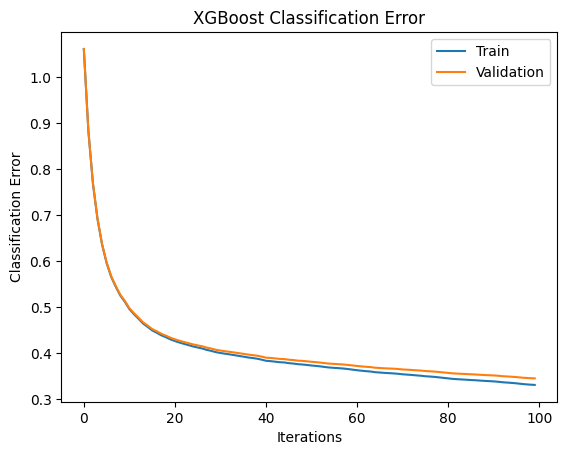

In [23]:
results = model.evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']

plt.plot(train_error, label='Train')
plt.plot(val_error, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.legend()
plt.show()

In [25]:
print("..................","balanced_accuracy_score","..................")
print(balanced_accuracy_score(y_test,model.predict(X_test)))
print("..................","confusion_matrix","..................")
print(confusion_matrix(y_test,model.predict(X_test)))
print("..................","classification_report","..................")
print(classification_report(y_test,model.predict(X_test)))


.................. balanced_accuracy_score ..................
0.8990186534632835
.................. confusion_matrix ..................
[[  6811    380     94      9]
 [ 26344 504508  60205   2246]
 [  4492  22401 219381   3454]
 [   317    558    993  26212]]
.................. classification_report ..................
              precision    recall  f1-score   support

           0       0.18      0.93      0.30      7294
           1       0.96      0.85      0.90    593303
           2       0.78      0.88      0.83    249728
           3       0.82      0.93      0.87     28080

    accuracy                           0.86    878405
   macro avg       0.68      0.90      0.73    878405
weighted avg       0.90      0.86      0.87    878405



## EDA and Feature Engineering

#### start with the numeric columns

In [28]:
numeric_col

['TMC',
 'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)']

#### Startlat and long indicates geography let's fetch s2ids out of it

In [29]:
accident_df['s2id11'] = accident_df.apply(lambda x: CellId.from_lat_lng(LatLng.from_degrees(x["Start_Lat"], x["Start_Lng"])).parent(11), axis=1)
accident_df['s2id12'] = accident_df.apply(lambda x: CellId.from_lat_lng(LatLng.from_degrees(x["Start_Lat"], x["Start_Lng"])).parent(12), axis=1)
accident_df['s2id10'] = accident_df.apply(lambda x: CellId.from_lat_lng(LatLng.from_degrees(x["Start_Lat"], x["Start_Lng"])).parent(10), axis=1)

In [30]:
cat_cols.extend(['s2id11','s2id12','s2id10'])

In [31]:
numeric_col.remove('Start_Lat')
numeric_col.remove('Start_Lng')

In [32]:
accident_df[numeric_col].describe()

,TMC,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
count,3.513617e+06,3.513617e+06,3.513617e+06,3.513617e+06,3.513617e+06,3.513617e+06,3.513617e+06
mean,2.080226e+02,2.816167e-01,6.193512e+01,6.511427e+01,2.974463e+01,9.122644e+00,8.219025e+00
std,1.744230e+01,1.550134e+00,1.844605e+01,2.252879e+01,8.253333e-01,2.854558e+00,4.910592e+00
min,2.000000e+02,0.000000e+00,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.010000e+02,0.000000e+00,5.000000e+01,4.900000e+01,2.974000e+01,1.000000e+01,5.000000e+00
50%,2.010000e+02,0.000000e+00,6.300000e+01,6.700000e+01,2.995000e+01,1.000000e+01,8.100000e+00
75%,2.080226e+02,1.000000e-02,7.570000e+01,8.400000e+01,3.009000e+01,1.000000e+01,1.040000e+01
max,4.060000e+02,3.336300e+02,1.706000e+02,1.000000e+02,5.774000e+01,1.400000e+02,9.840000e+02


#### detect and fix outliers

In [50]:
for col in numeric_col:
    Q1 = accident_df[col].quantile(0.25)
    Q3 = accident_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    outliers = accident_df[(accident_df[col] < lower_threshold) | (accident_df[col] > upper_threshold)]
    print(col, len(outliers))
# cleaned_df = df[~((df[column_name] - mean).abs() > threshold * std_dev)]
# print(outliers)

TMC 373200
Distance(mi) 746426
Temperature(F) 26158
Humidity(%) 0
Pressure(in) 419044
Visibility(mi) 777062
Wind_Speed(mph) 94375


#### check distrubution for every class

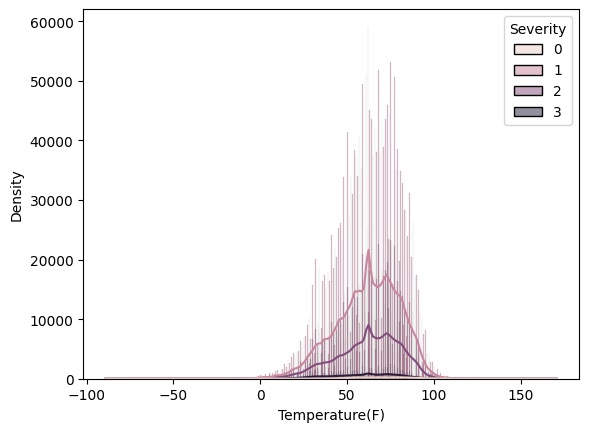

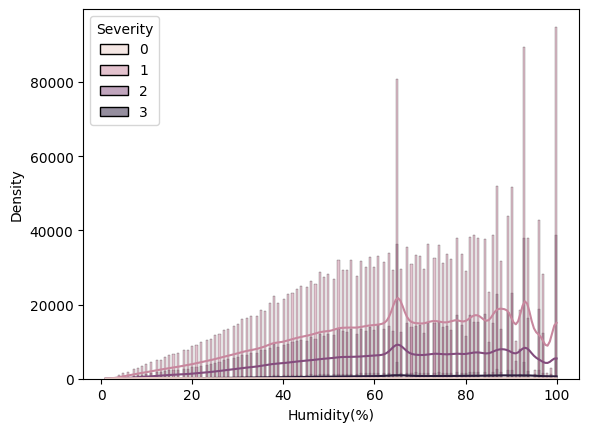

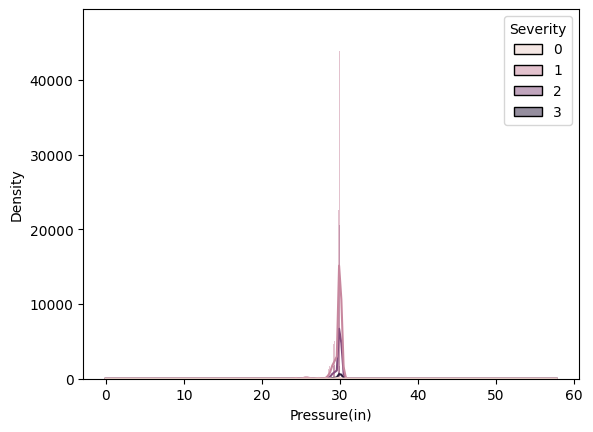

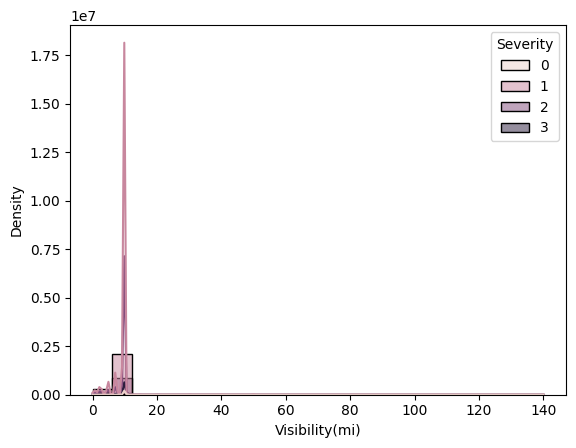

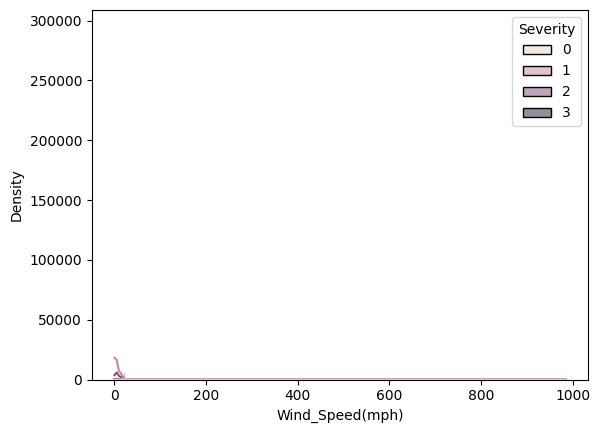

In [33]:
for col in numeric_col:
    if col not in ["TMC","Distance(mi)"]:
        sns.histplot(data=accident_df, x=col, hue='Severity', kde=True)
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()
    

#### Parse date features

In [34]:
datetime_cols

['Start_Time', 'End_Time', 'Weather_Timestamp']

In [35]:
accident_df['start_hour'] = accident_df['Start_Time'].dt.hour
accident_df['start_weekday'] = accident_df['Start_Time'].dt.day_name()

accident_df['end_hour'] = accident_df['End_Time'].dt.hour
accident_df['end_weekday'] = accident_df['End_Time'].dt.day_name()

accident_df['weather_hour'] = accident_df['Weather_Timestamp'].dt.hour
accident_df['weather_weekday'] = accident_df['Weather_Timestamp'].dt.day_name()


In [36]:
(accident_df['start_weekday'] == accident_df['weather_weekday']).value_counts()

True     3477346
False      36271
Name: count, dtype: int64

In [37]:
(accident_df['start_weekday'] == accident_df['end_weekday']).value_counts()

True     3413699
False      99918
Name: count, dtype: int64

In [38]:
cat_cols.extend(['start_hour','start_weekday','end_hour','end_weekday','weather_hour','weather_weekday'])

In [39]:
cardinality_managable = []
for col in cat_cols:
    cardinality = len(accident_df[col].unique())
    if cardinality <= 50:
        cardinality_managable.append(col)
    print(col,cardinality)

Source 3
Description 1780092
Street 176262
Side 3
City 11895
County 1724
State 49
Zipcode 418780
Timezone 4
Airport_Code 2001
Wind_Direction 24
Weather_Condition 127
Amenity 2
Bump 2
Crossing 2
Give_Way 2
Junction 2
No_Exit 2
Railway 2
Roundabout 2
Station 2
Stop 2
Traffic_Calming 2
Traffic_Signal 2
Sunrise_Sunset 2
Civil_Twilight 2
Nautical_Twilight 2
Astronomical_Twilight 2
s2id11 68547
s2id12 133420
s2id10 32156
start_hour 24
start_weekday 7
end_hour 24
end_weekday 7
weather_hour 24
weather_weekday 7


In [40]:
cat_cols.remove('Description')
cat_cols.remove('Street')


In [41]:
sns.set(rc={'figure.figsize':(12,5)})

#### check distrubution of categorical variables

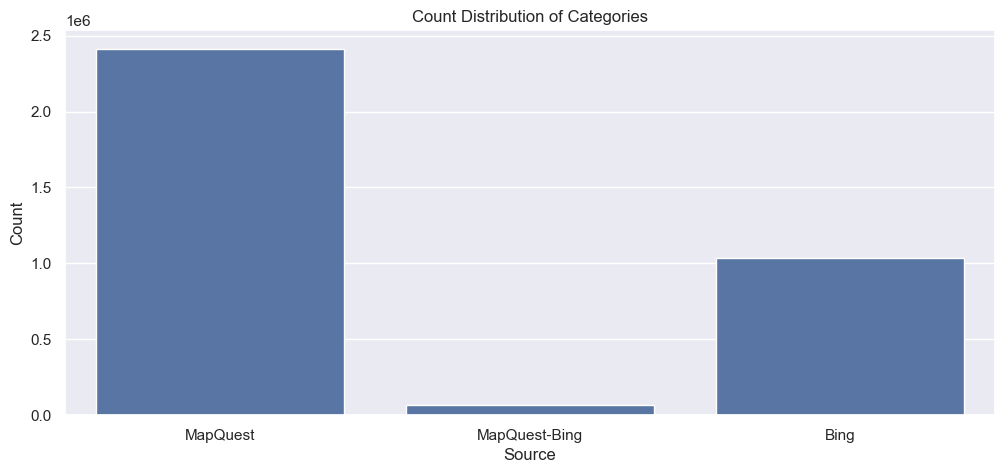

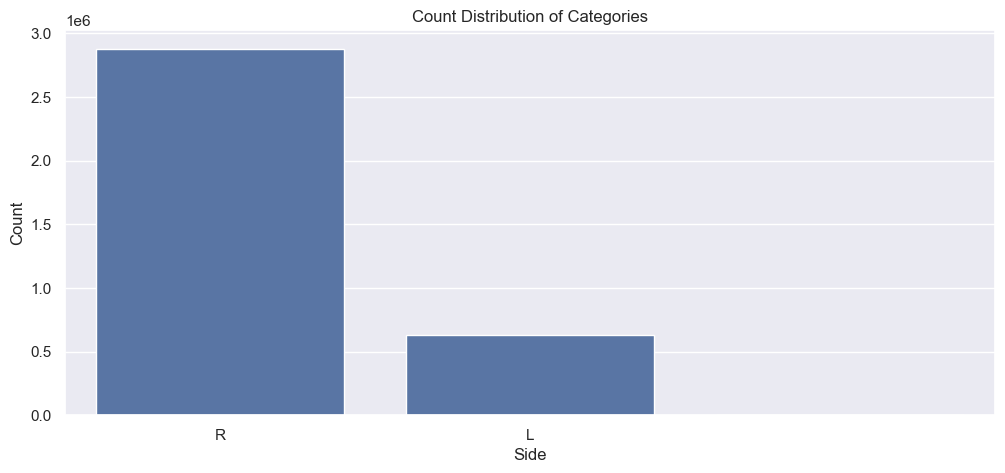

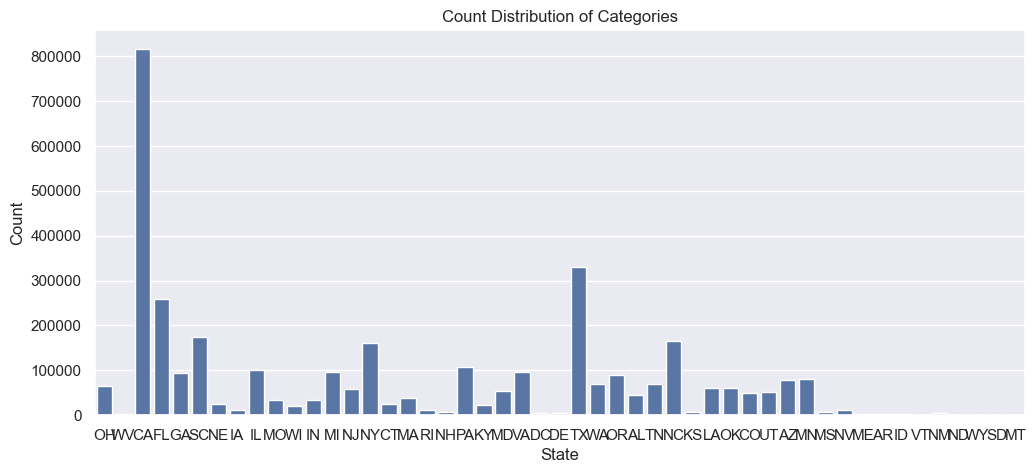

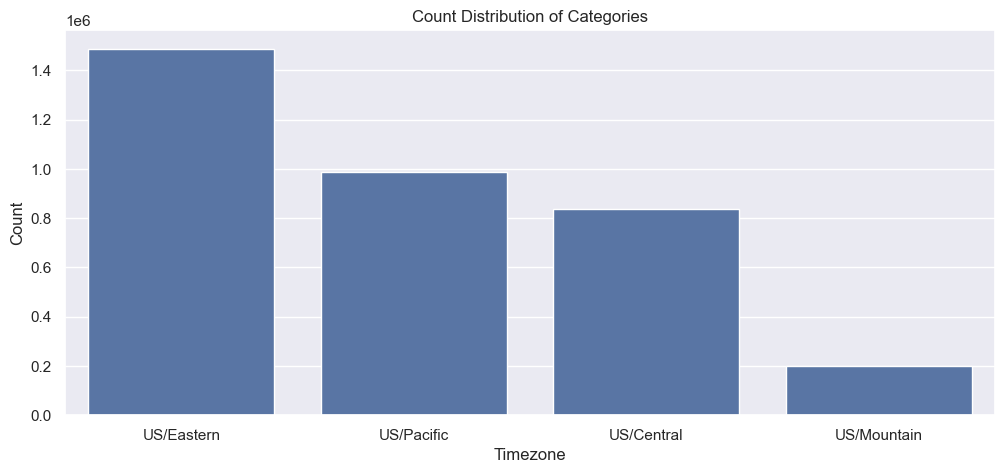

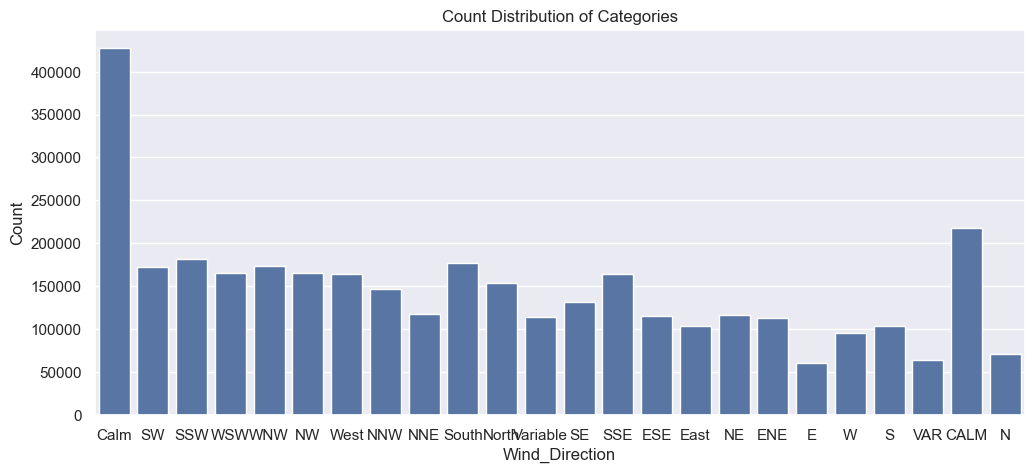

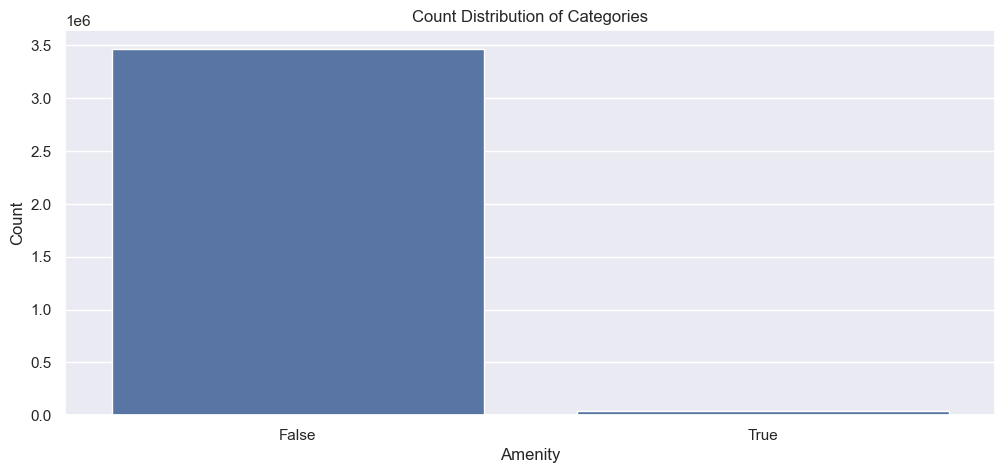

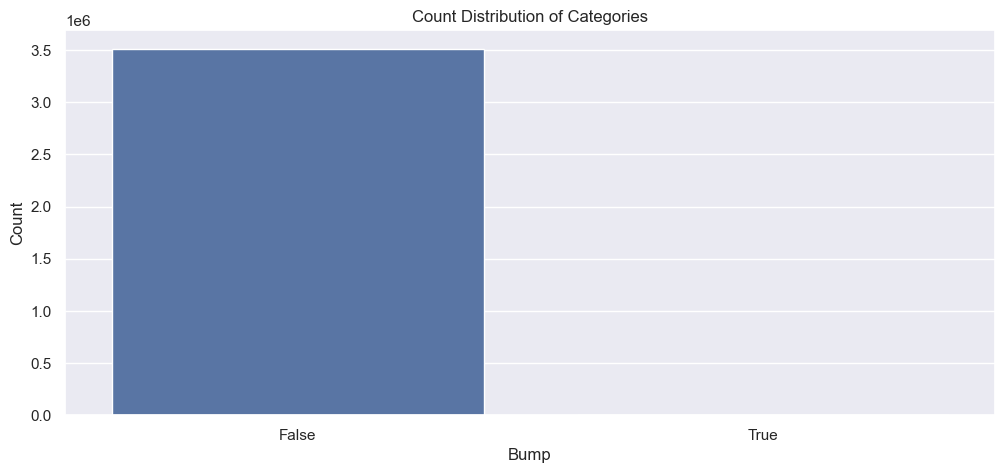

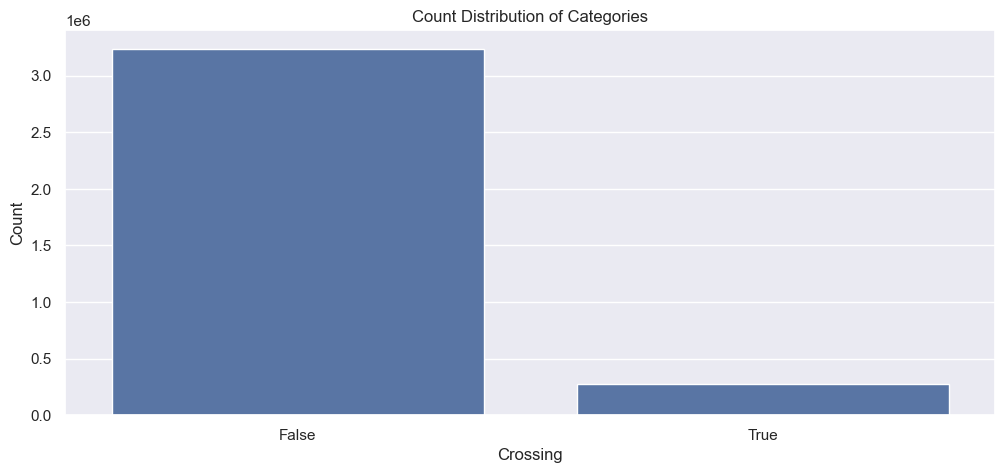

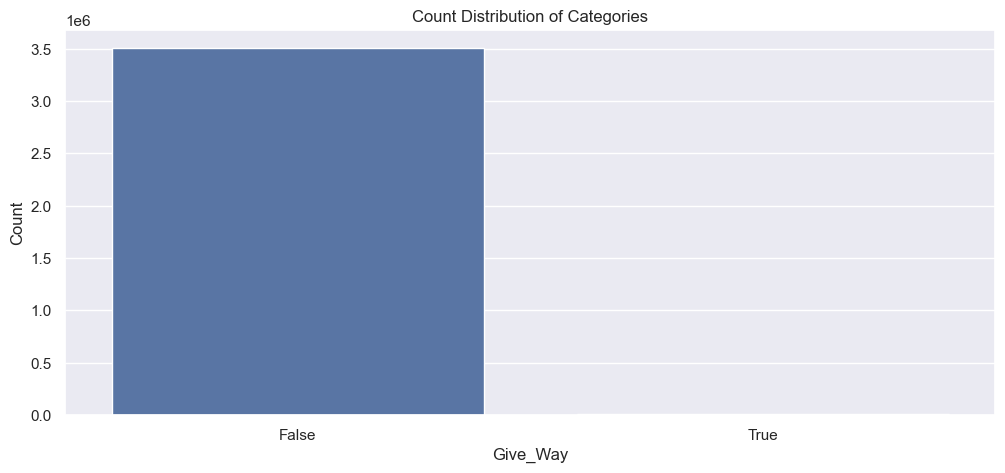

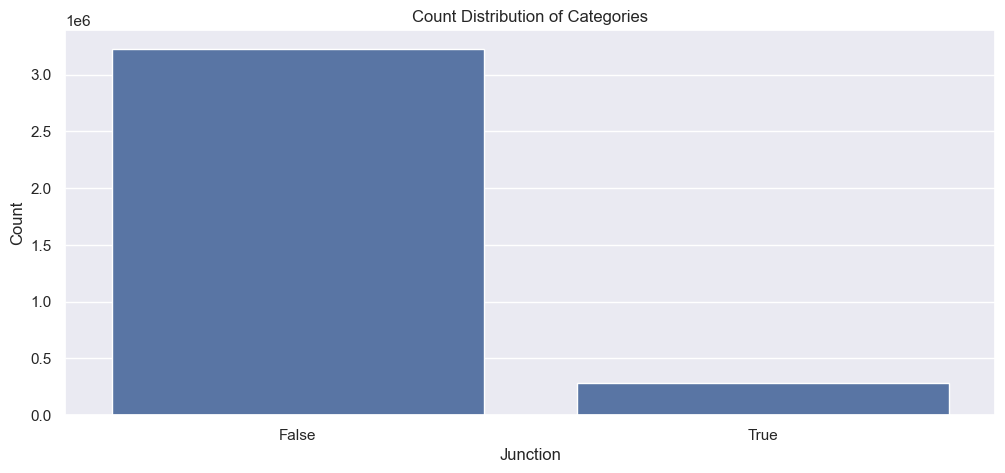

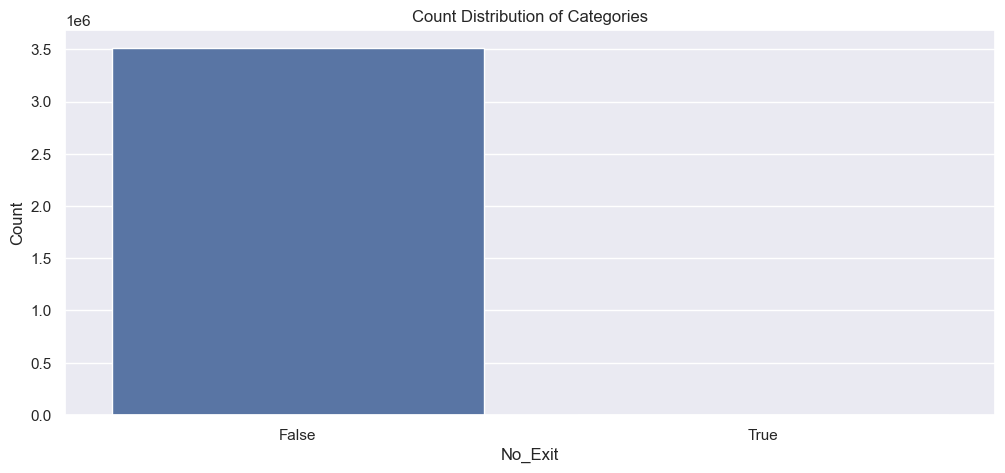

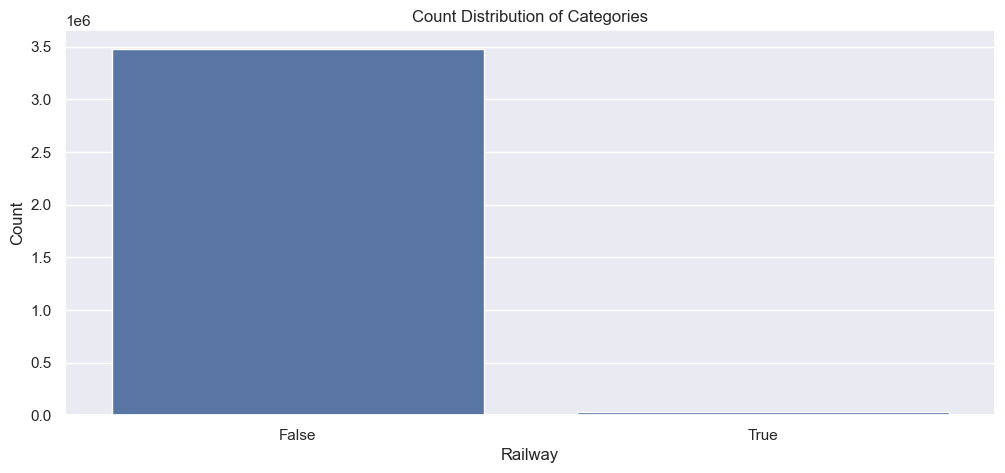

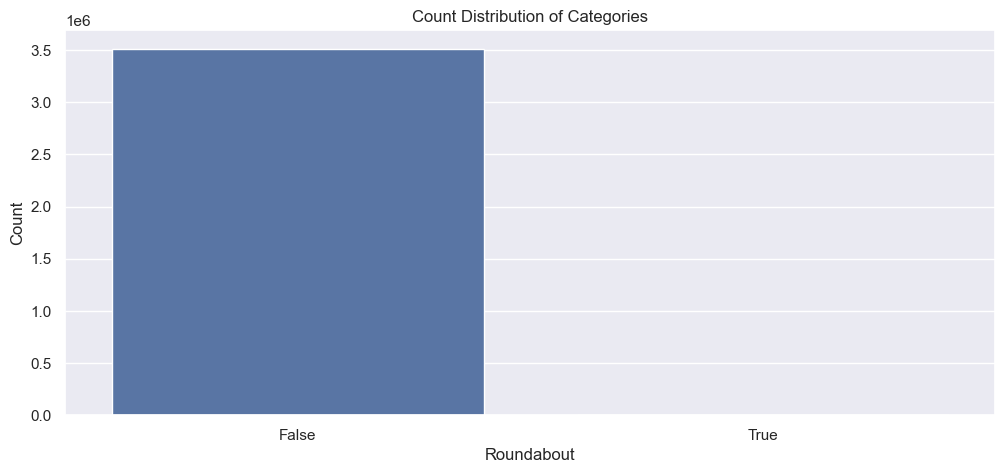

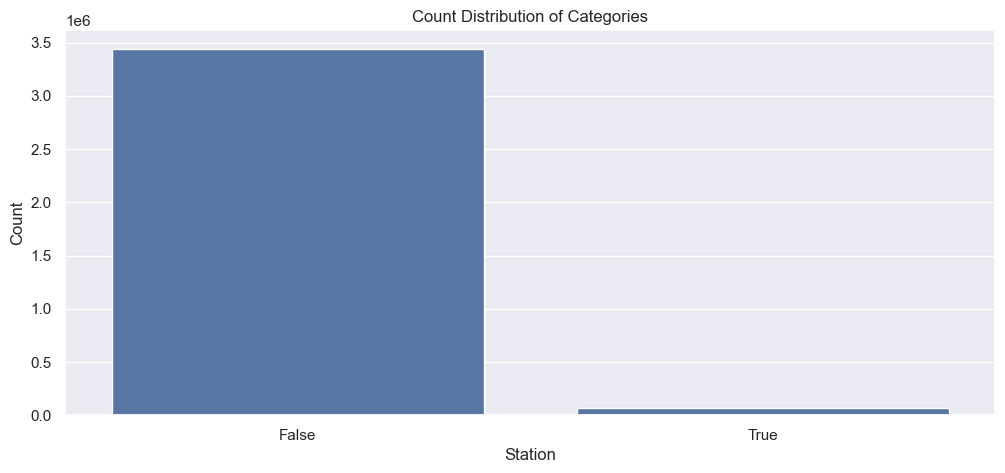

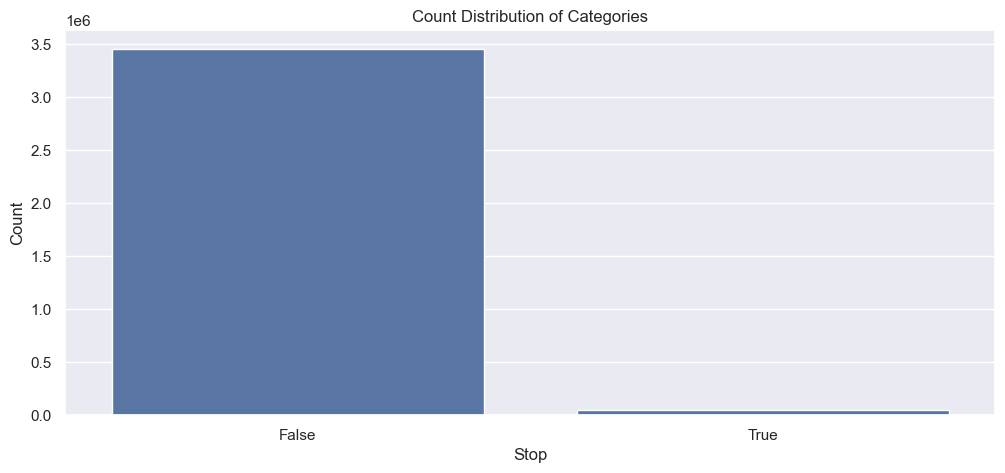

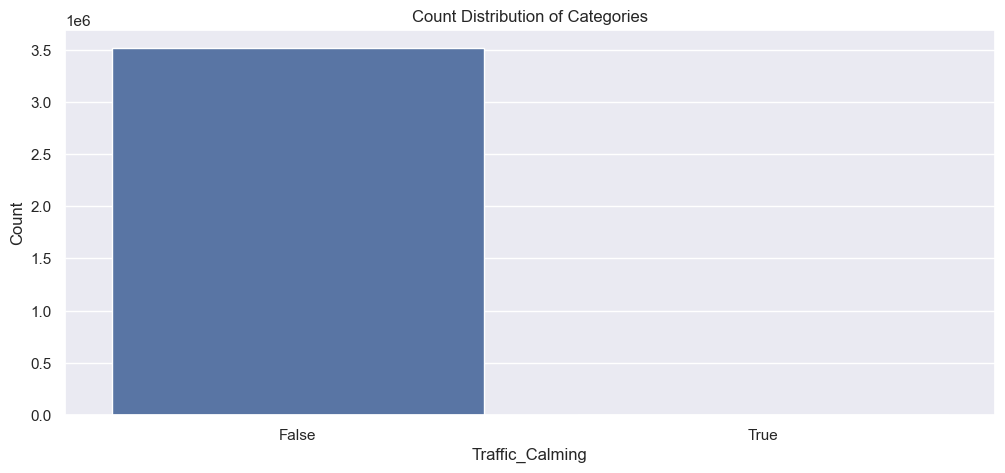

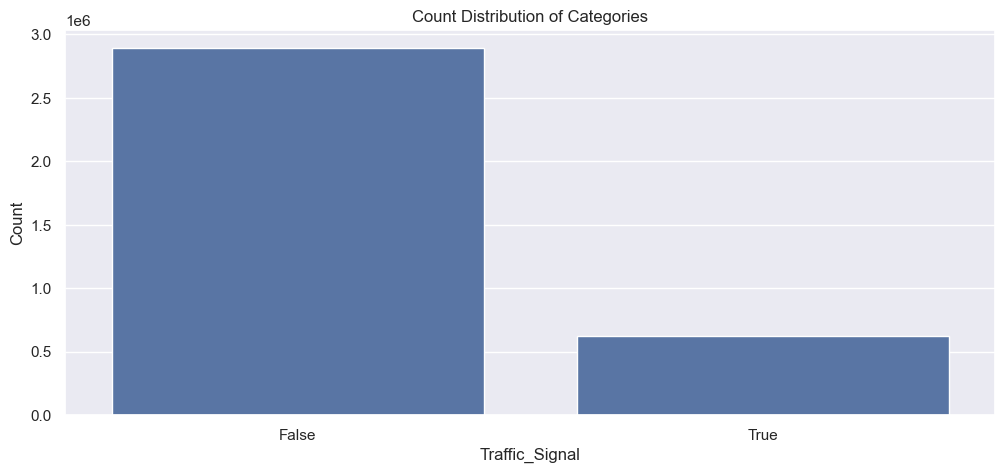

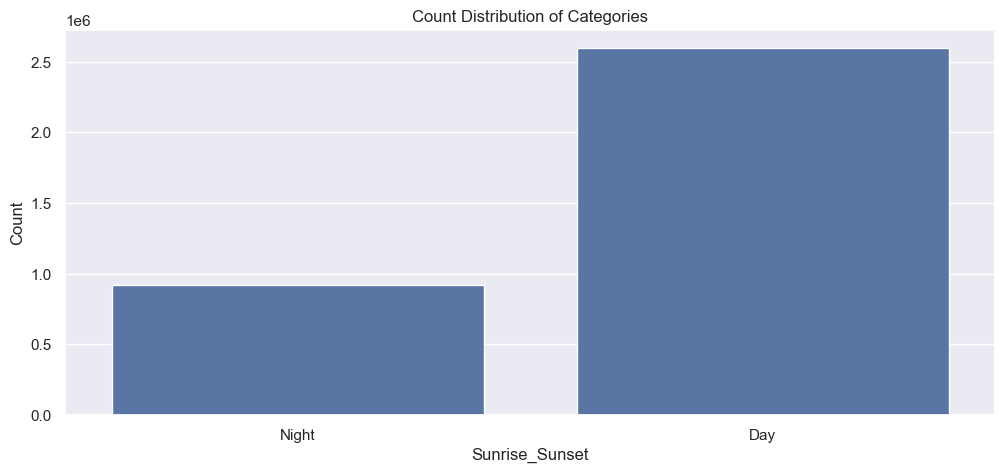

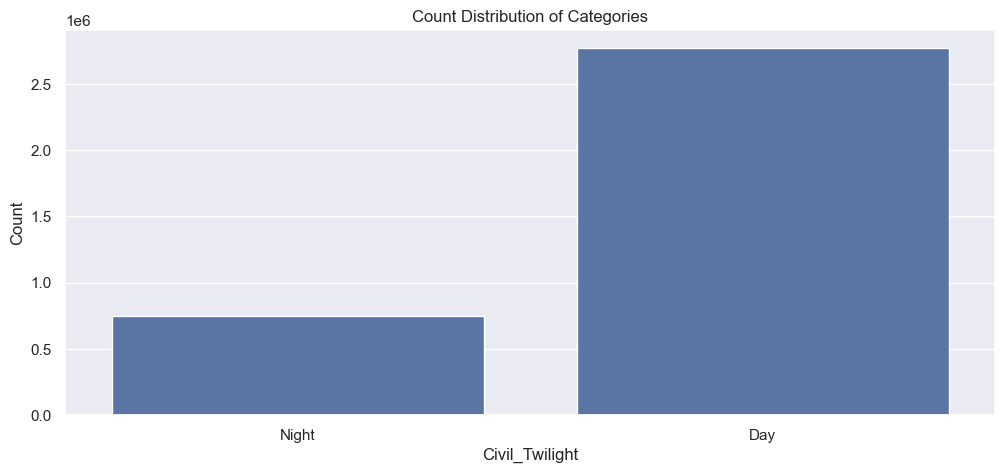

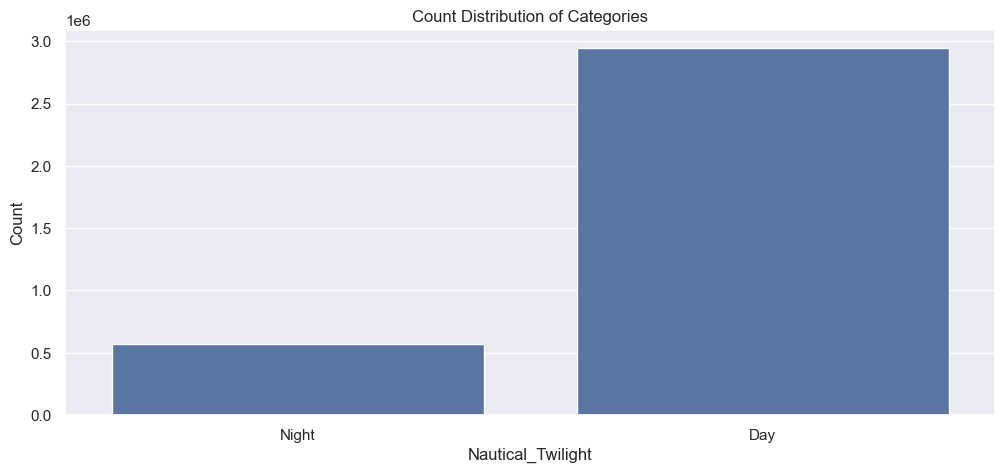

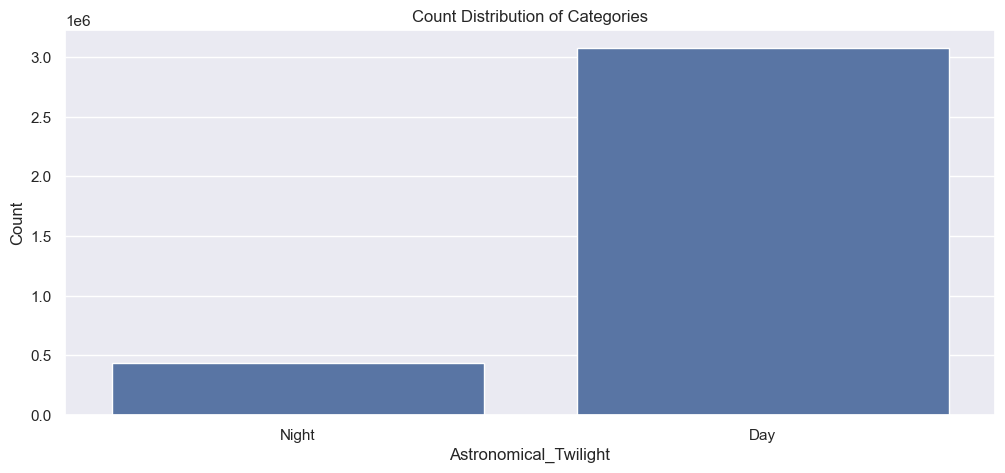

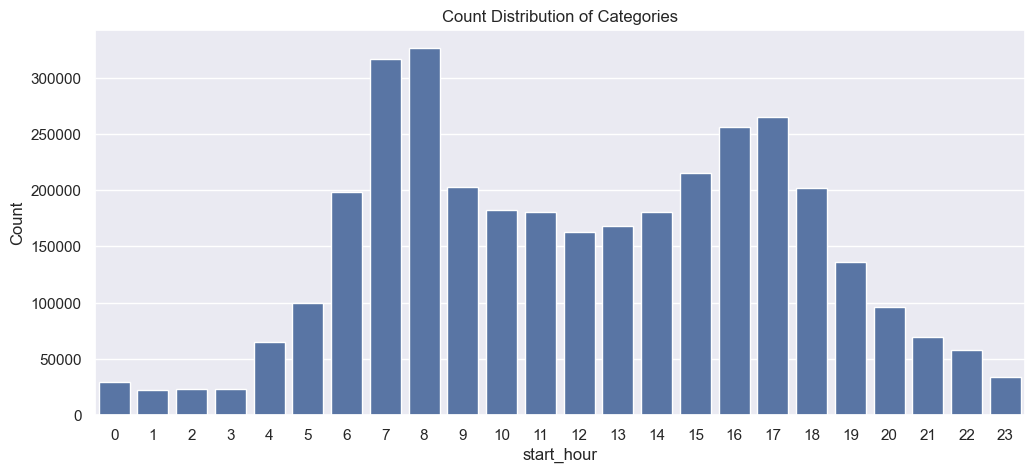

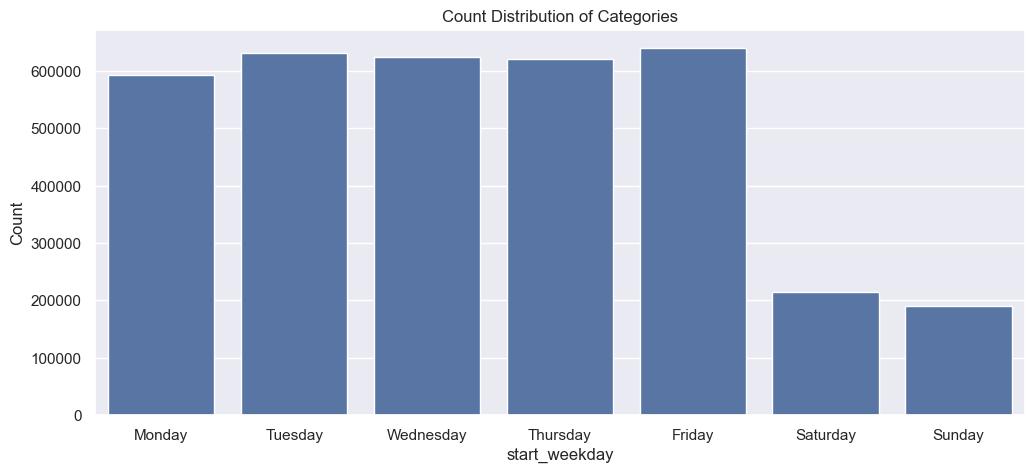

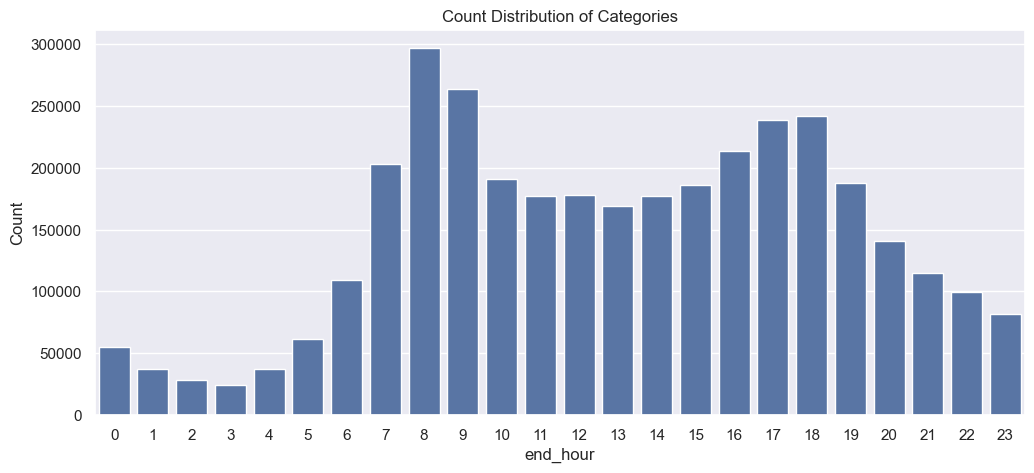

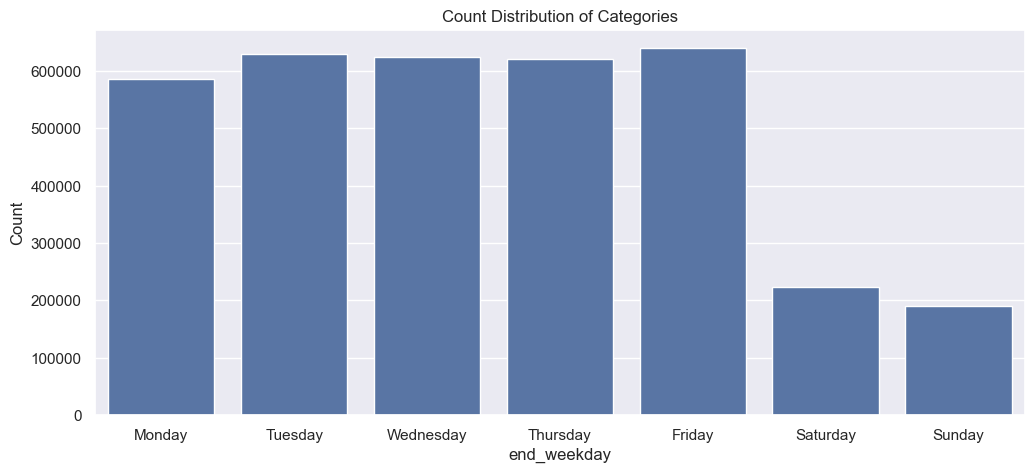

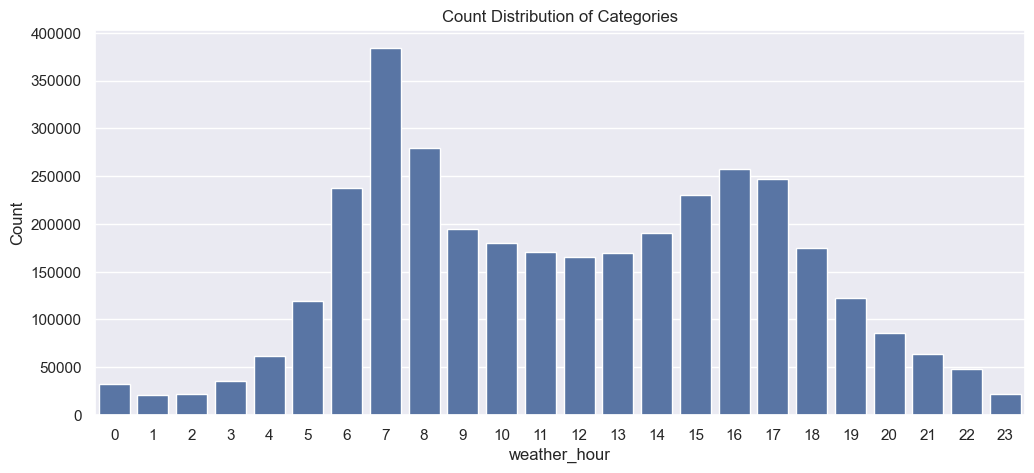

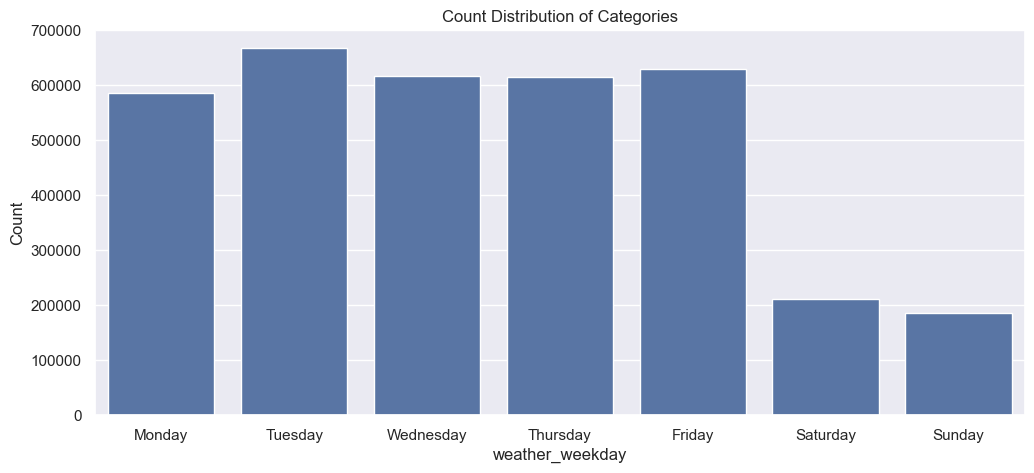

In [42]:
for col in cardinality_managable:
    sns.countplot(data=accident_df, x=col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Count Distribution of Categories')
    plt.show()

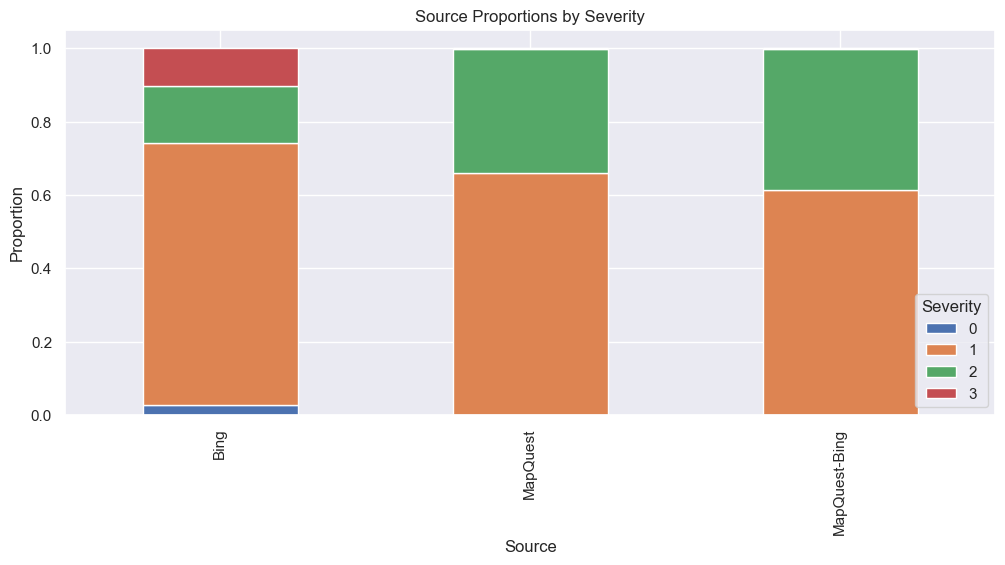

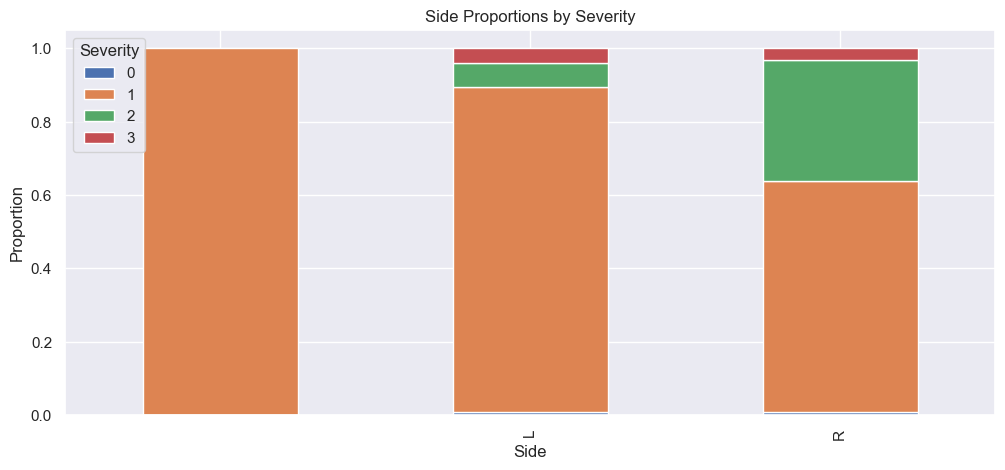

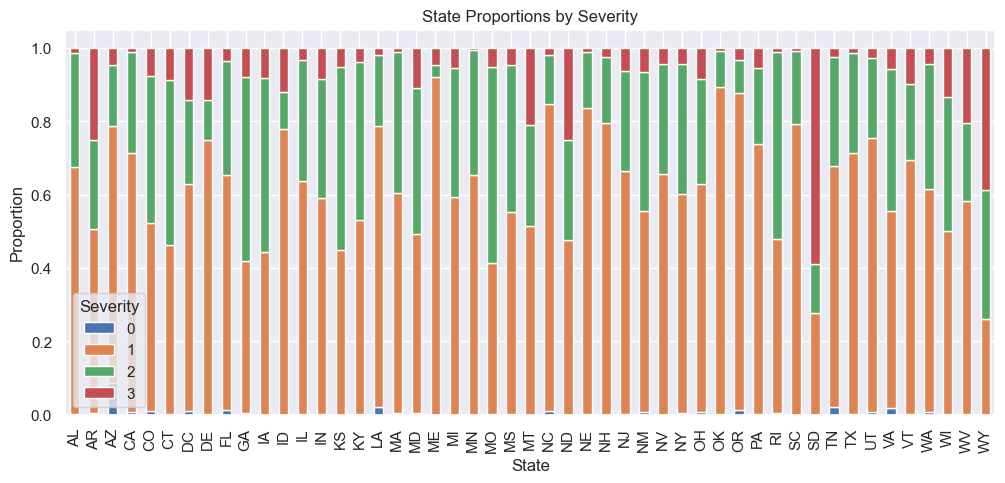

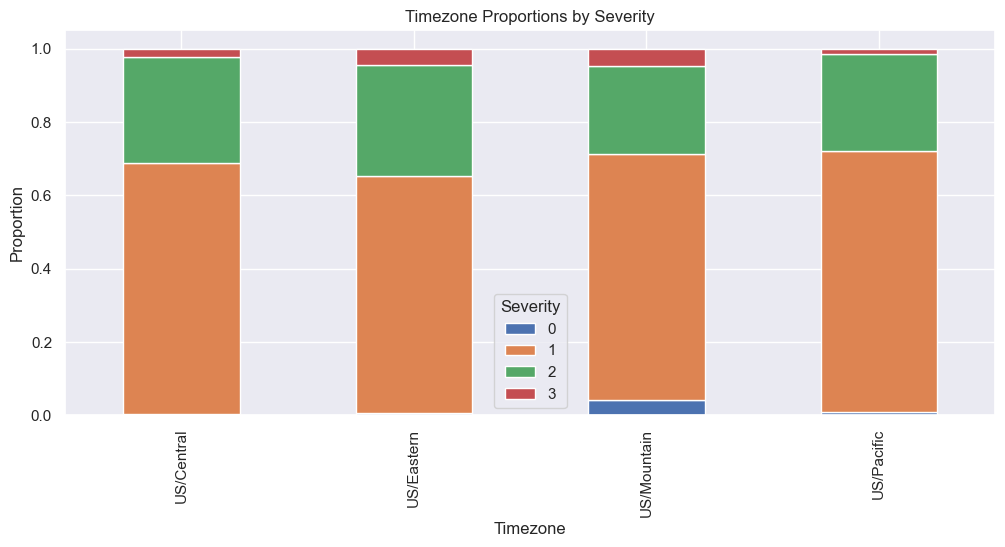

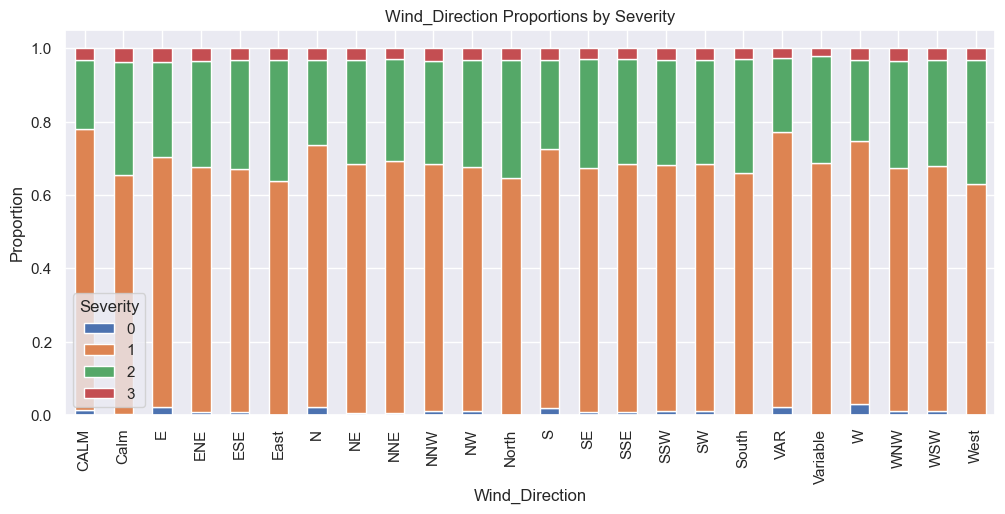

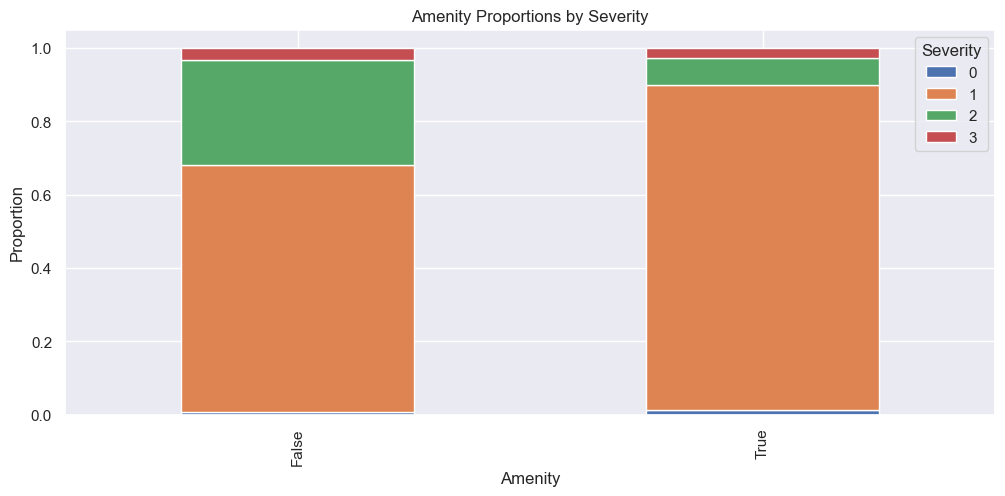

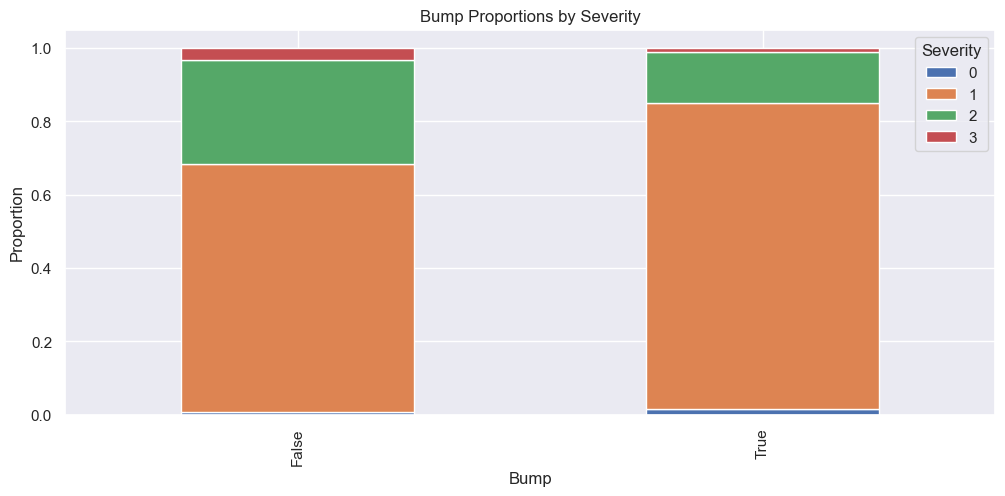

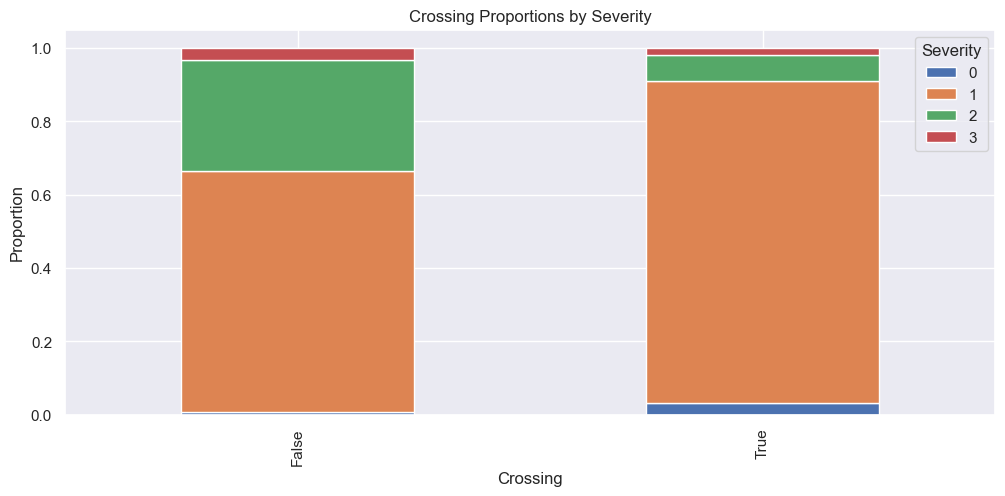

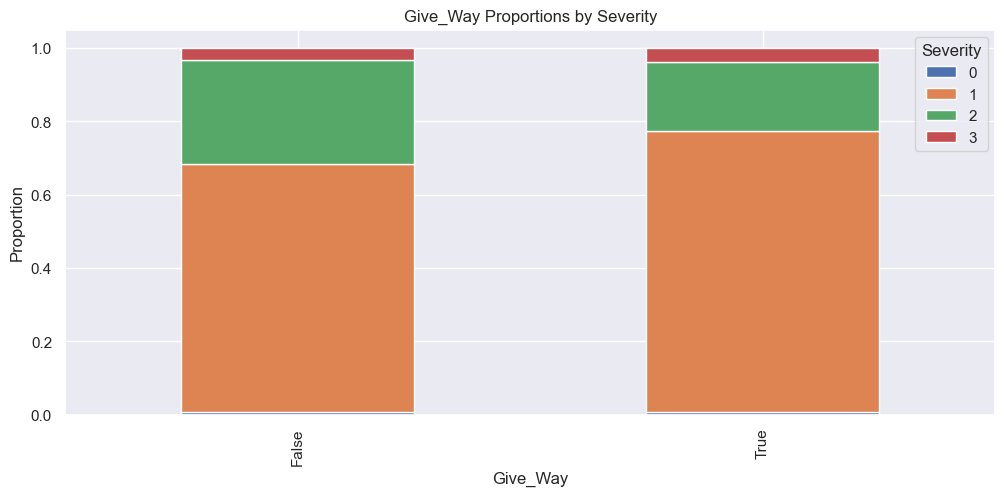

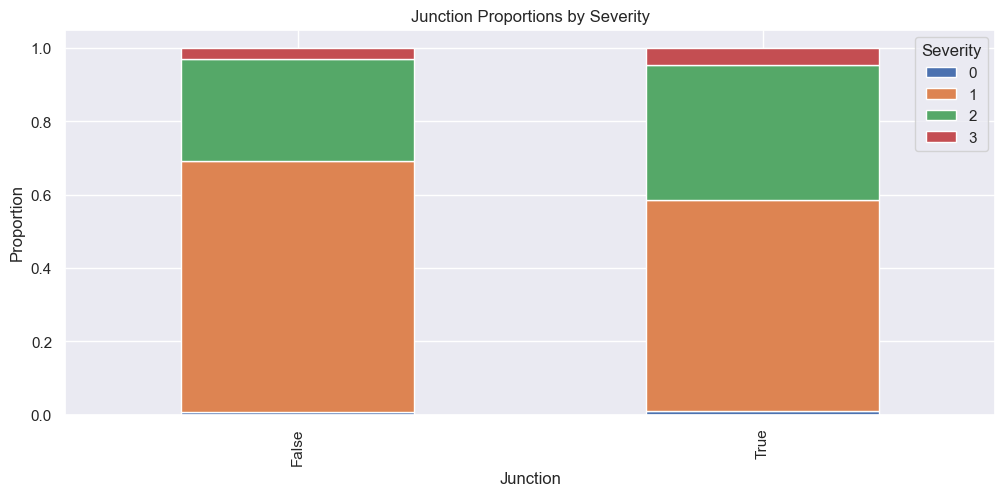

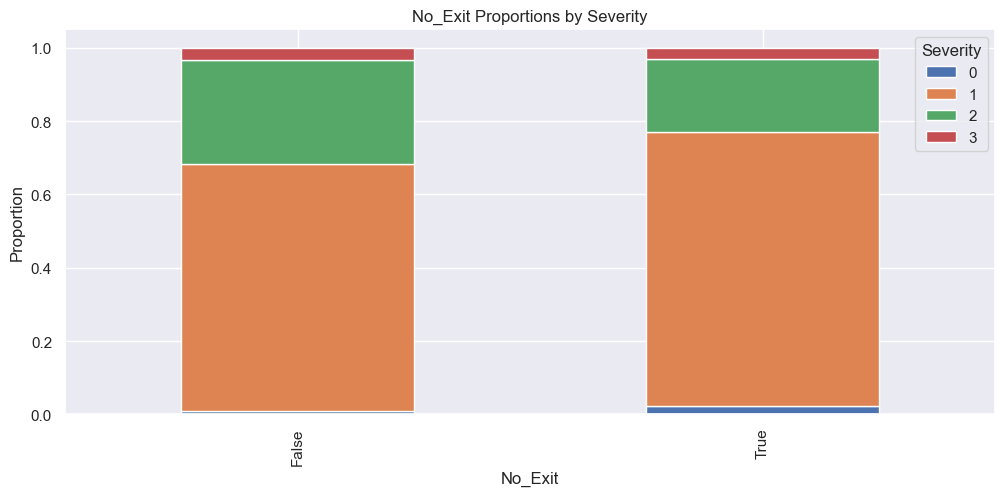

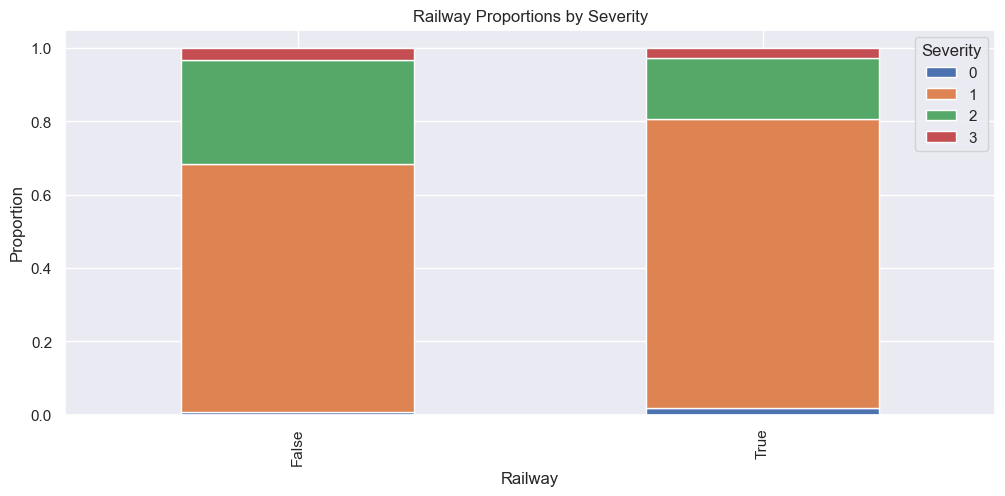

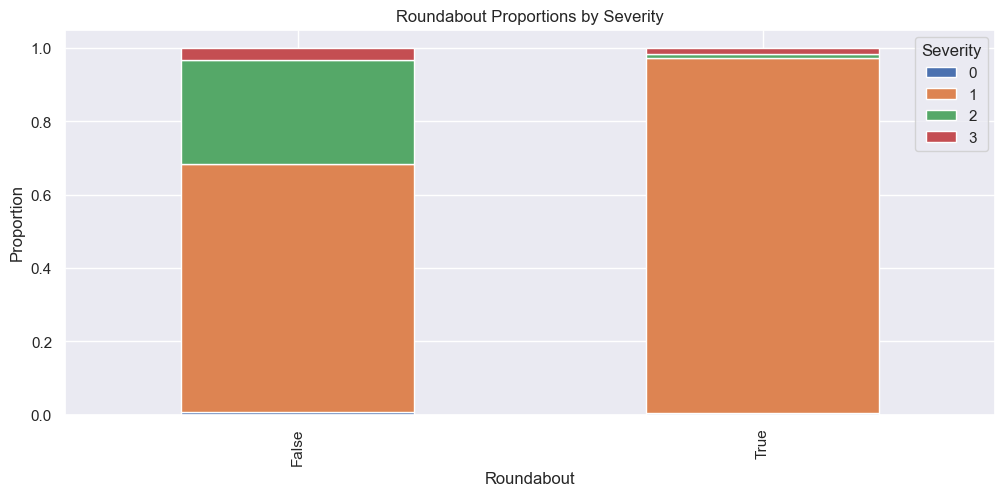

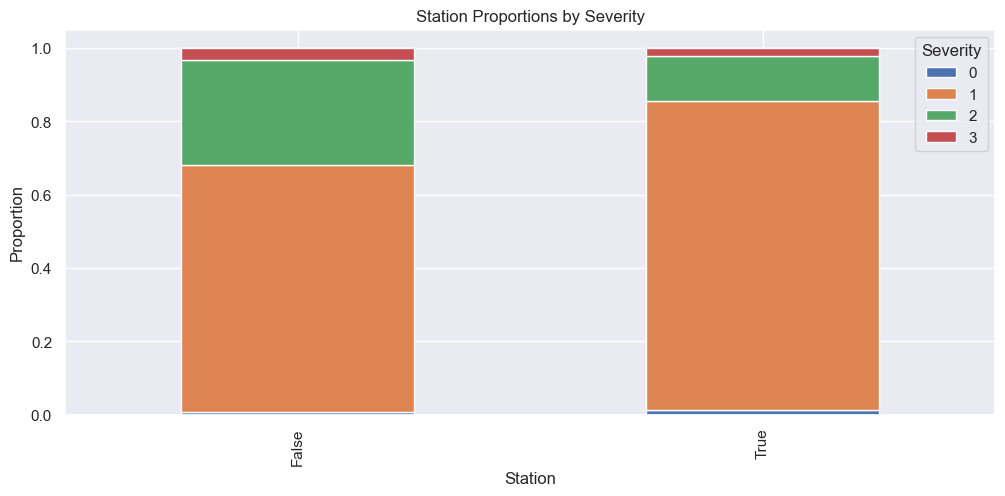

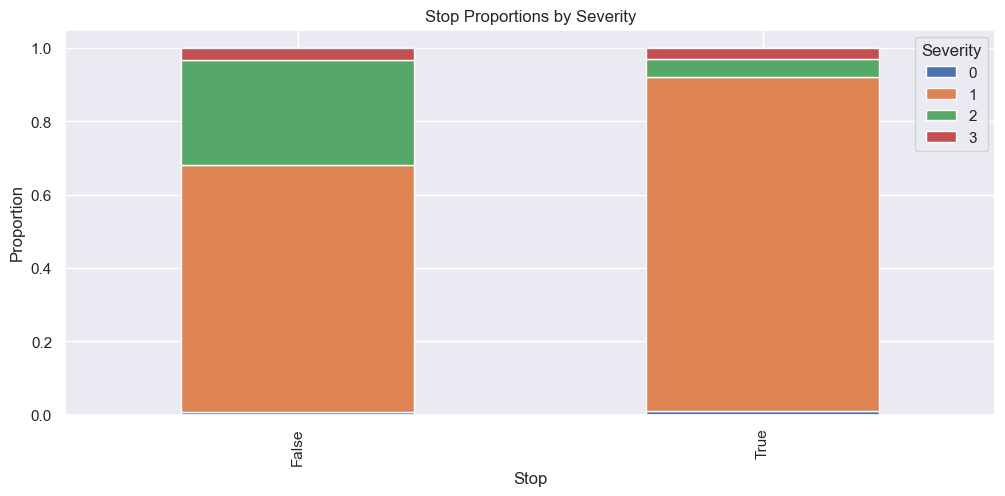

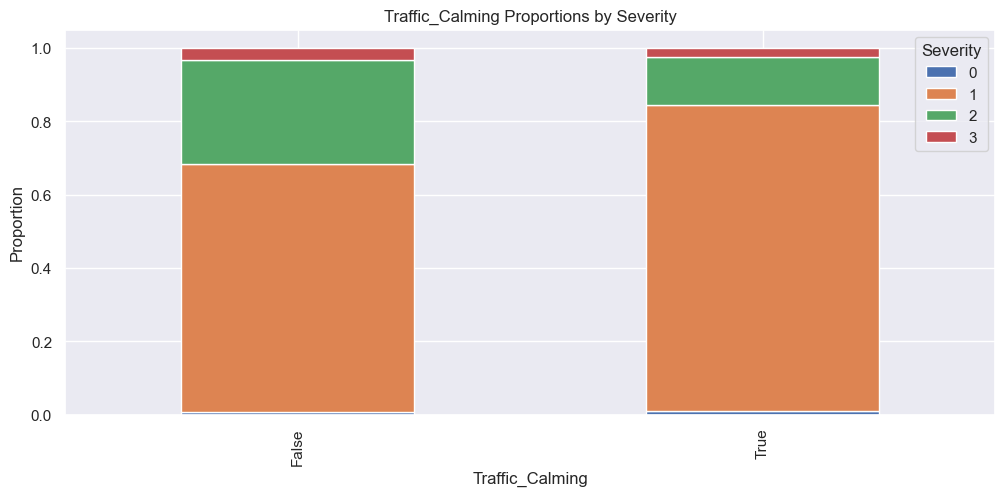

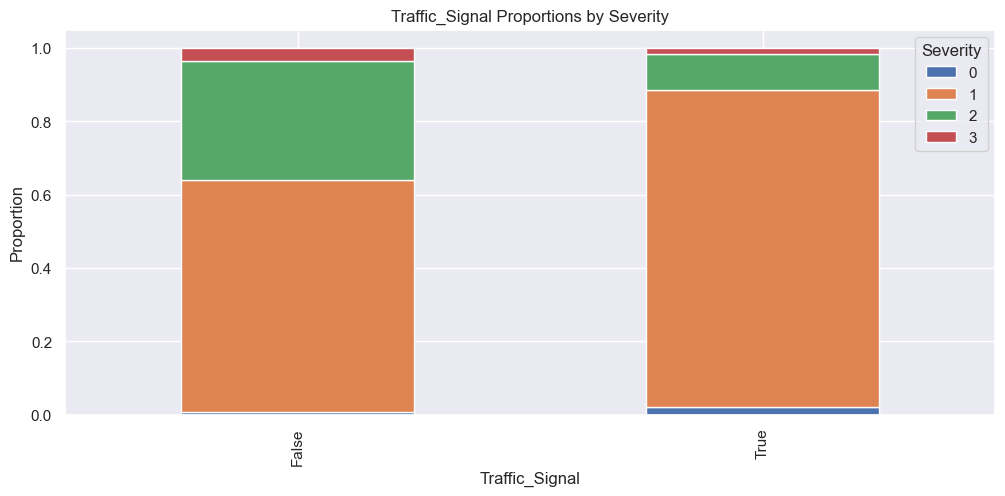

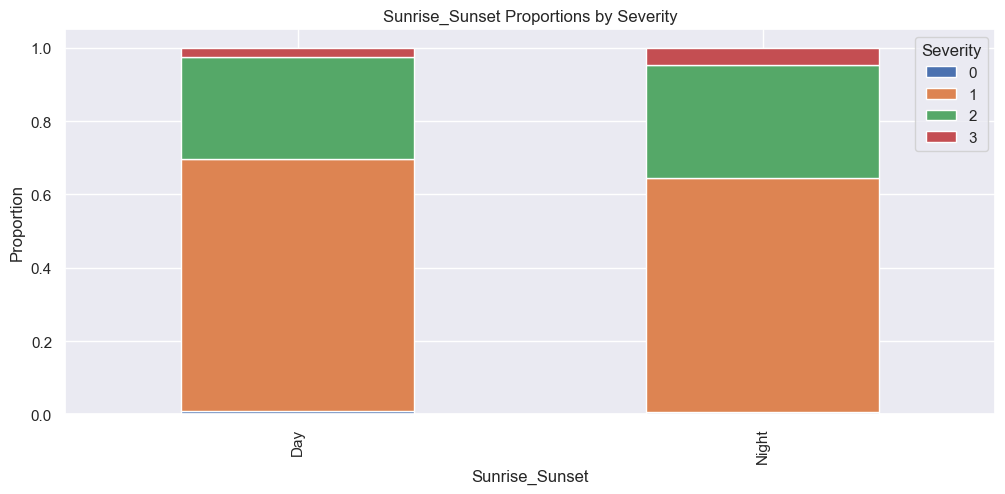

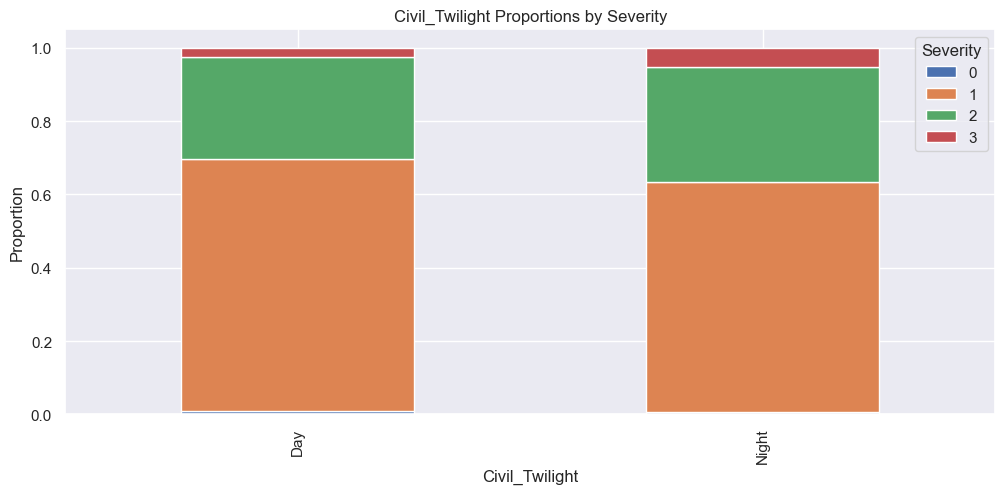

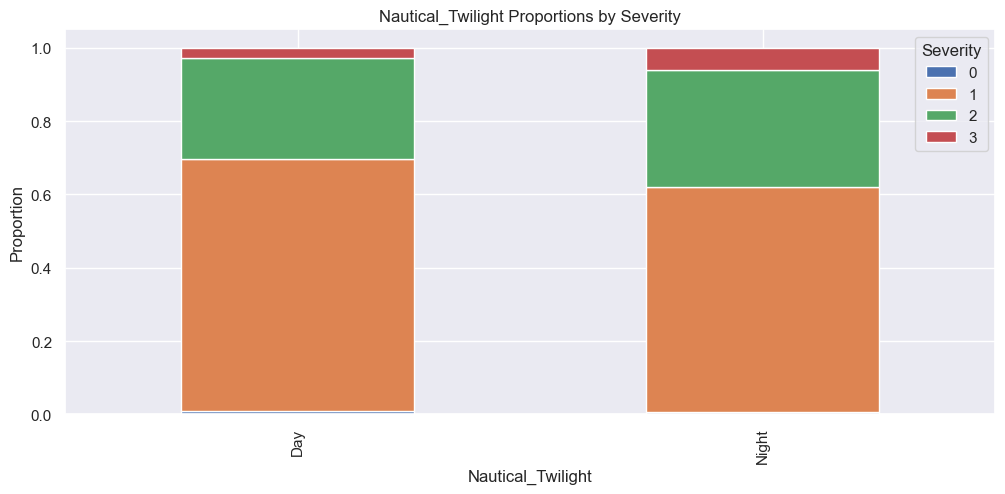

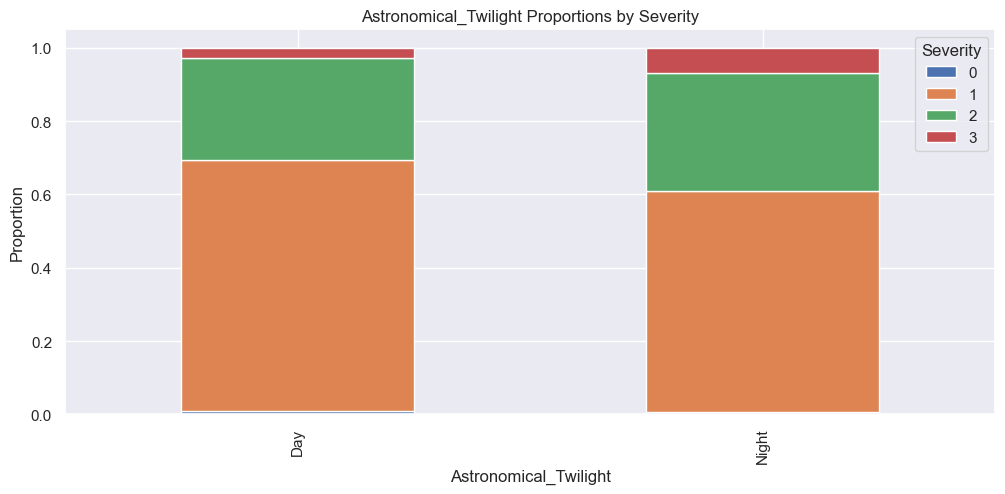

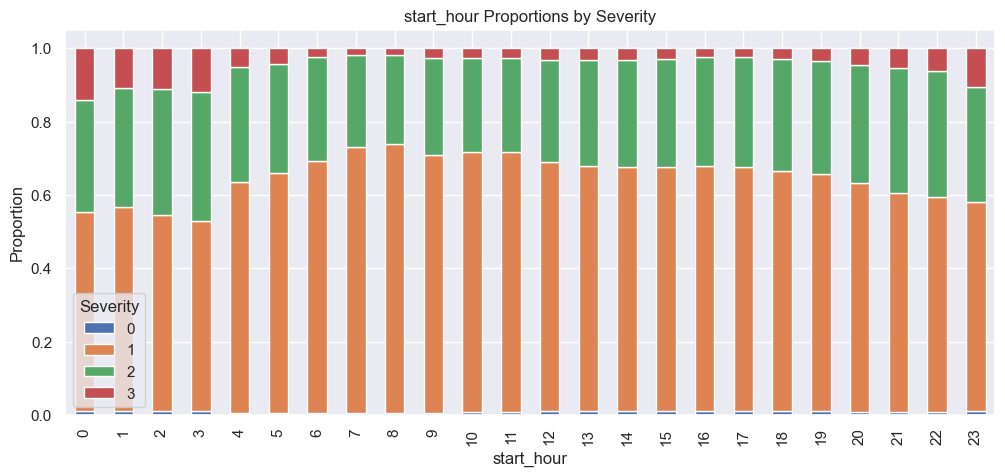

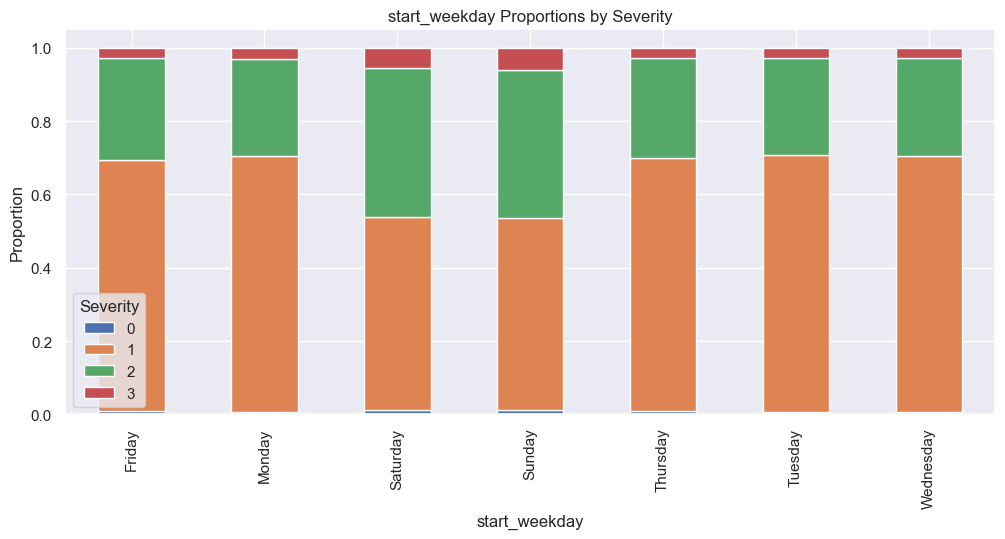

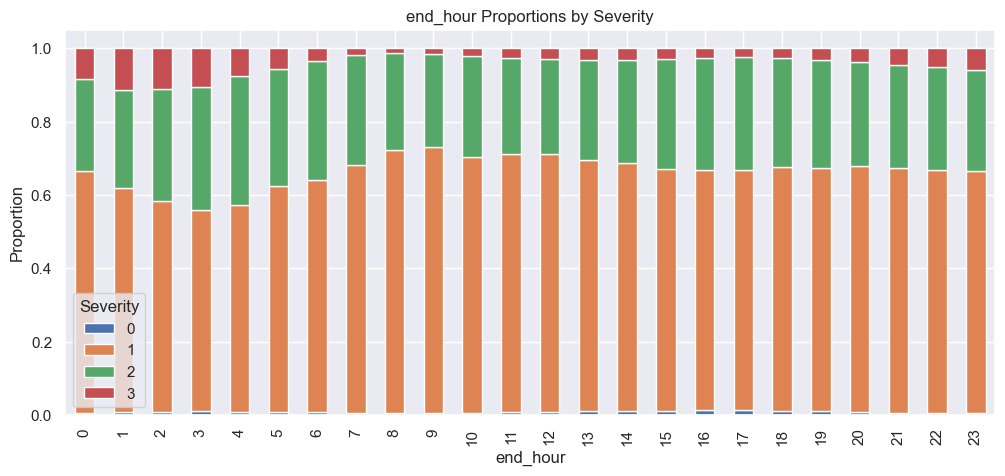

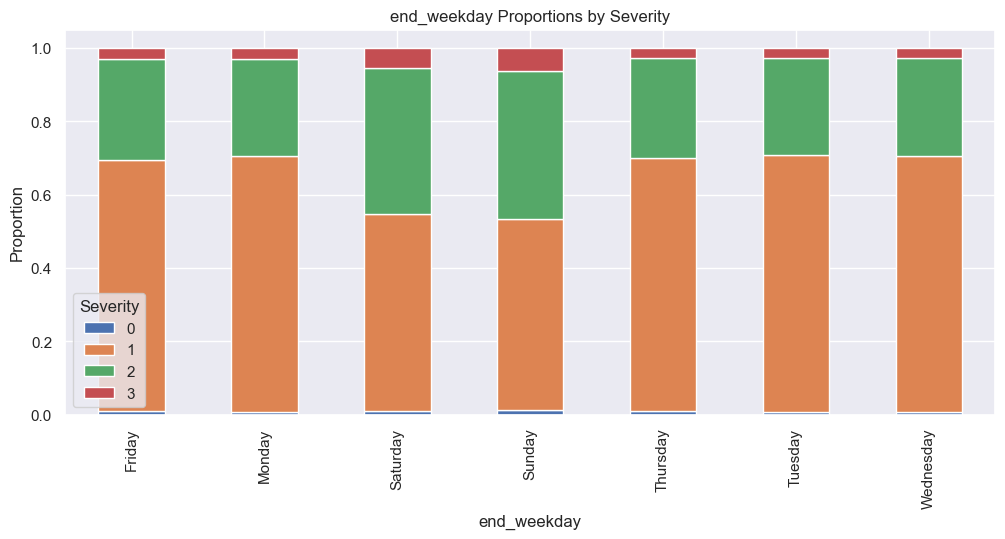

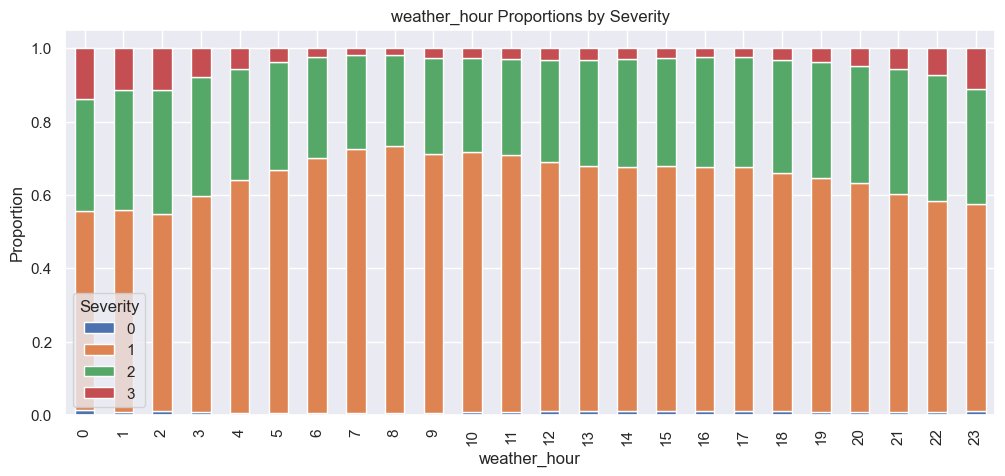

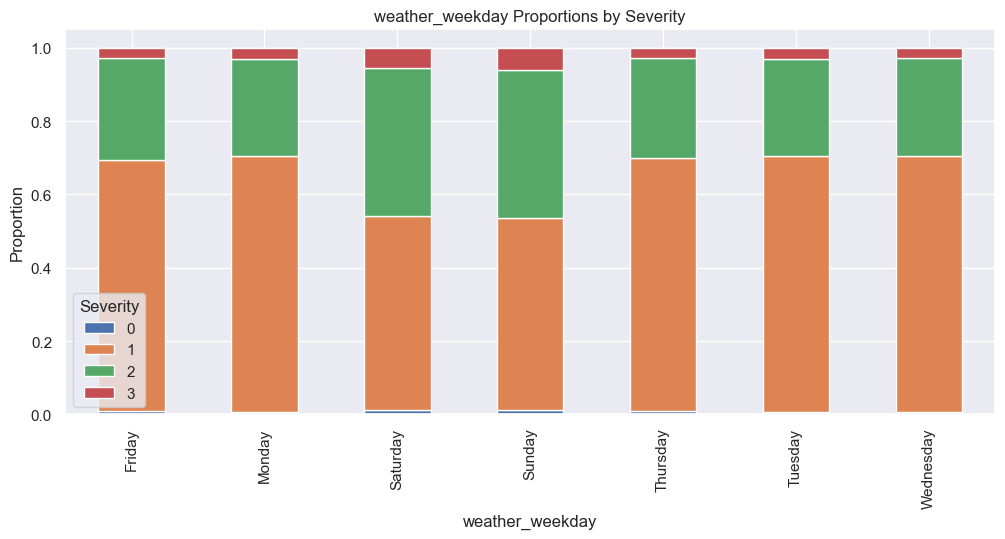

In [43]:
for col in cardinality_managable:
    pd.crosstab(accident_df[col], accident_df['Severity'], normalize='index').plot(kind='bar', stacked=True)
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.title('{} Proportions by Severity'.format(col))
    plt.show()

In [44]:
accident_df.corr(numeric_only=True)

,TMC,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,start_hour,end_hour,weather_hour
TMC,1.000000,0.132548,-0.004648,-0.013342,0.036178,0.002480,0.005720,-0.018078,0.000645,0.000516,...,-0.002544,-0.008831,-0.001980,-0.016775,-0.019428,-0.002551,-0.054610,-0.014998,-0.013366,-0.016821
Severity,0.132548,1.000000,0.047617,0.083705,0.150326,-0.026995,0.033946,0.038041,-0.006354,0.032531,...,-0.006705,-0.023492,-0.003956,-0.048260,-0.053500,-0.006073,-0.191531,0.022523,-0.004361,0.023013
Start_Lat,-0.004648,0.047617,1.000000,-0.013994,0.062742,-0.423506,0.043480,-0.097423,-0.049907,0.050824,...,0.000233,-0.000314,-0.000280,0.016133,0.011216,0.009136,-0.091752,-0.008326,-0.013005,-0.007152
Start_Lng,-0.013342,0.083705,-0.013994,1.000000,0.048143,-0.061980,0.178299,0.148174,-0.046965,0.078150,...,-0.002869,-0.023936,0.000794,-0.011009,-0.040357,-0.006283,0.087513,-0.042898,-0.027893,-0.041144
Distance(mi),0.036178,0.150326,0.062742,0.048143,1.000000,-0.037682,0.018801,-0.026954,-0.010916,0.013578,...,-0.003175,-0.011938,-0.001164,-0.022232,-0.011501,-0.001232,-0.069620,0.000863,0.005419,0.000603
Temperature(F),0.002480,-0.026995,-0.423506,-0.061980,-0.037682,1.000000,-0.338245,-0.020917,0.179952,-0.006335,...,0.003861,0.005617,-0.001033,0.003460,0.000837,-0.001209,0.061557,0.207398,0.212970,0.206153
Humidity(%),0.005720,0.033946,0.043480,0.178299,0.018801,-0.338245,1.000000,0.111317,-0.379323,-0.135304,...,-0.009447,-0.002628,0.001706,-0.002904,-0.013017,-0.000300,-0.034668,-0.306913,-0.303955,-0.301547
Pressure(in),-0.018078,0.038041,-0.097423,0.148174,-0.026954,-0.020917,0.111317,1.000000,-0.011852,0.001093,...,-0.009990,0.010594,0.001661,0.020156,-0.008631,-0.000388,-0.010763,-0.022469,-0.024507,-0.022823
Visibility(mi),0.000645,-0.006354,-0.049907,-0.046965,-0.010916,0.179952,-0.379323,-0.011852,1.000000,0.014350,...,0.011639,0.003023,0.000042,0.006894,0.005876,0.003197,0.029561,0.093206,0.084481,0.087160
Wind_Speed(mph),0.000516,0.032531,0.050824,0.078150,0.013578,-0.006335,-0.135304,0.001093,0.014350,1.000000,...,0.000768,-0.004057,-0.001278,-0.000066,0.003201,-0.002163,0.016229,0.115425,0.122574,0.114771


In [45]:
crr = accident_df[numeric_col+['Severity']].corr()

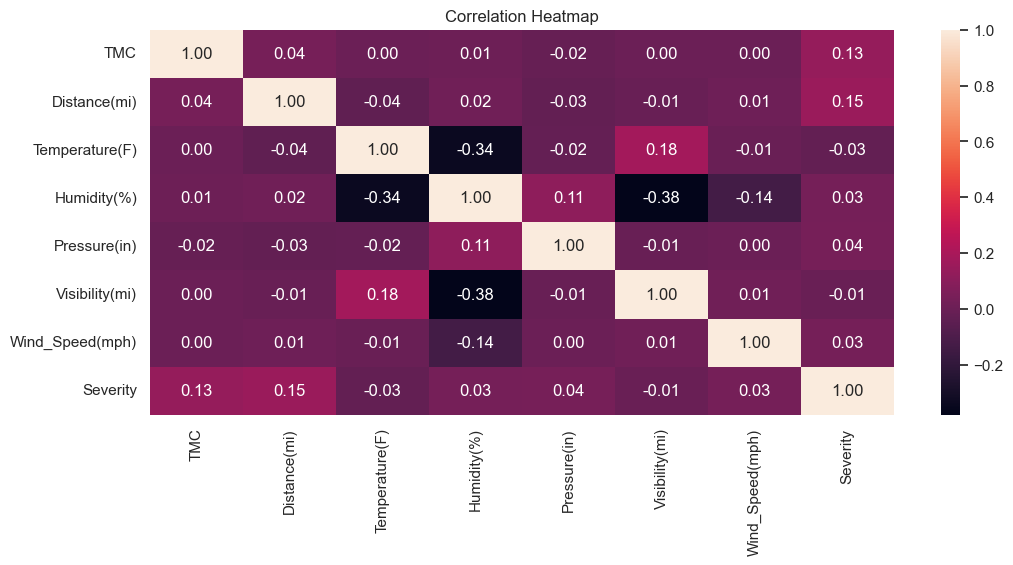

In [46]:
sns.heatmap(crr, annot=True,  fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Detect and Remove highly correlated features

In [47]:
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.8,
    missing_values="ignore",
    selection_method="variance",
#     estimator='variance',
    scoring="roc_auc",
    cv=3,
)


# find correlated features

sel.fit(accident_df)
sel.correlated_feature_sets_


[{'start_hour', 'weather_hour'}]

In [48]:
cat_cols.remove('weather_hour')

# text based feature engineering

In [51]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm.auto import tqdm
tqdm.pandas()
nltk.download('punkt')
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercase
    tokens = [token for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    return " ".join(tokens)




[nltk_data] Downloading package punkt to /Users/dhruvshah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dhruvshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
accident_df['clean_description'] = accident_df['Description'].progress_apply(preprocess_text)



  0%|          | 0/3513617 [00:00<?, ?it/s]

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=30)
X_train_vectors = vectorizer.fit_transform(accident_df["clean_description"])


In [57]:
text_df = pd.DataFrame(X_train_vectors.todense(),columns=vectorizer.get_feature_names_out())

# Final Model

In [68]:
scaler = StandardScaler()
X = pd.concat([pd.DataFrame(scaler.fit_transform(accident_df[numeric_col]),columns = numeric_col),accident_df[cat_cols],text_df],axis=1)
y = accident_df[target_column]

In [69]:
for col in cat_cols:
    encode = LabelEncoder()
    X[col] = encode.fit_transform(X[col])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.25, stratify= y, random_state=0)

In [71]:
weights = compute_sample_weight(class_weight="balanced",y = y_train)
set(weights)

{0.37013338337340096,
 0.8793595707335304,
 7.820548433048433,
 30.109826325411333}

In [77]:
model_v2 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth = 12,
    objective = 'multi:softmax',
    eval_metrics=['merror','mlogloss'],
    early_stopping_rounds=30,
    num_class = 4,
    random_state=42,
    n_jobs=4

)


model_v2.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], sample_weight=weights, verbose=0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [02:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None,
              eval_metrics=['merror', 'mlogloss'], feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=4, num_class=4, ...)

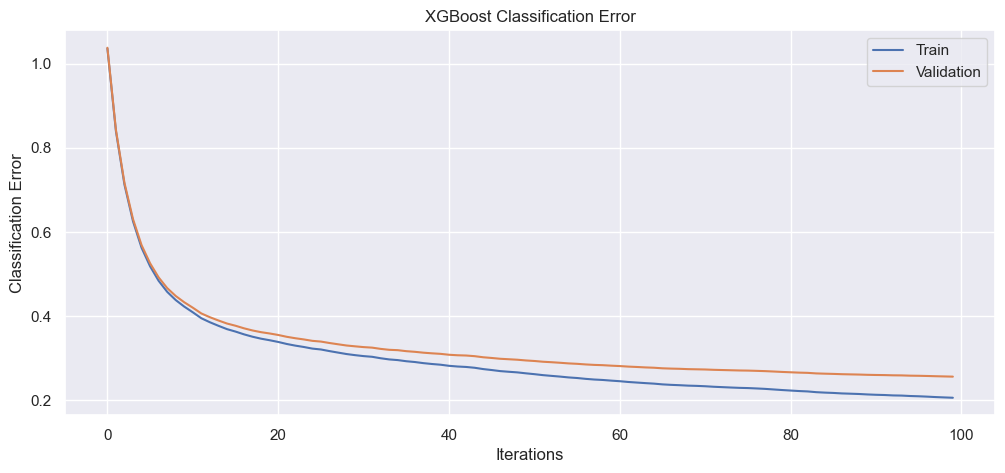

In [78]:
results = model_v2.evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']

plt.plot(train_error, label='Train')
plt.plot(val_error, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.legend()
plt.show()

In [79]:
print("..................","balanced_accuracy_score","..................")
print(balanced_accuracy_score(y_test,model_v2.predict(X_test)))
print("..................","confusion_matrix","..................")
print(confusion_matrix(y_test,model_v2.predict(X_test)))
print("..................","classification_report","..................")
print(classification_report(y_test,model_v2.predict(X_test)))


.................. balanced_accuracy_score ..................
0.9096382455375159
.................. confusion_matrix ..................
[[  6601    512    170     11]
 [  6820 532670  53246    567]
 [  1481  21133 225592   1522]
 [   108    416   1374  26182]]
.................. classification_report ..................
              precision    recall  f1-score   support

           0       0.44      0.90      0.59      7294
           1       0.96      0.90      0.93    593303
           2       0.80      0.90      0.85    249728
           3       0.93      0.93      0.93     28080

    accuracy                           0.90    878405
   macro avg       0.78      0.91      0.83    878405
weighted avg       0.91      0.90      0.90    878405



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

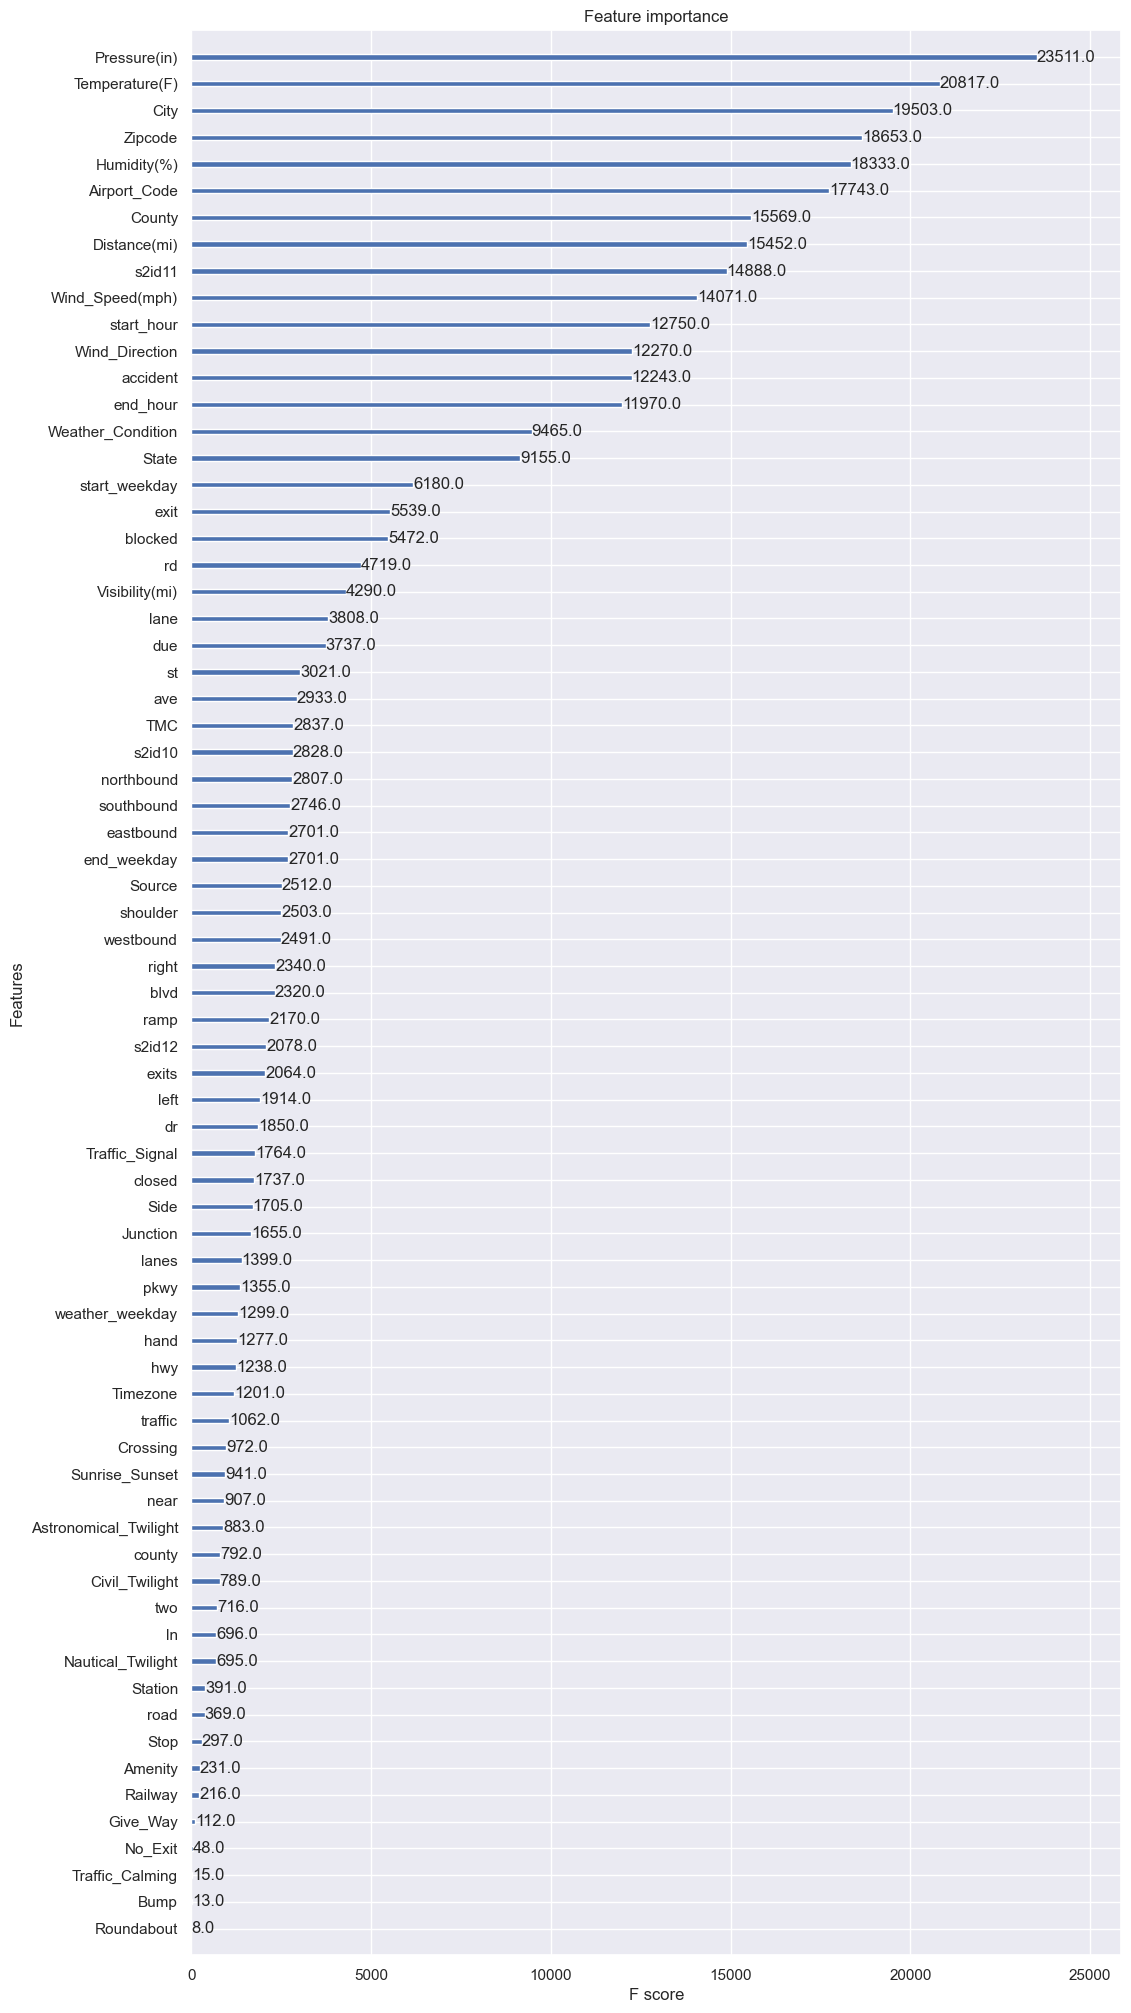

In [81]:
from xgboost import plot_importance
fix, ax = plt.subplots( figsize=(12,25))
plot_importance(model_v2, ax=ax)